# Modelling Wind Speed and Direction Distribution using Gaussain Mixture Modles (OEN method)

OEN Method: Harris, Cook
The parent wind speed distribution: Why Weibull?
http://www.sciencedirect.com/science/article/pii/S0167610514001056

Gaussian Mixture Modles, 
http://scikit-learn.org/stable/modules/mixture.html

# 1. Set up

## 1.1 Environment

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from import_file import *
load_libs()

## 1.2 Read Data

In [2]:
# ipath= './data/NCDC/uk/boscombe_down/dat.txt' # weird shape at 3, try 4
# ipath= './data/NCDC/uk/middle_wallop/dat.txt'
# ipath= './data/NCDC/uk/southhamption/dat.txt'
# ipath= './data/NCDC/uk/bournemouth/dat.txt'
# ipath= './data/NCDC/tiree.txt'
# ipath= "./data/NCDC/marham.txt"
ipath= "./data/NCDC/uk/holbeach/dat.txt"
# ipath= "./data/NCDC/uk/weybourne/dat.txt"
# ipath= "./data/NCDC/uk/cambridge/dat.txt"
# ipath= "./data/NCDC/uk/wattisham/dat.txt"
# ipath= "./data/NCDC/uk/lakenheath/dat.txt" # irregular sampling time
# ipath= "./data/NCDC/uk/mildenhall/dat.txt" # irregular sampling time

# ipath= "./data/NCDC/southeast_asia/paya_lebar/dat.txt" # recent 5 year maybe corrupted
# ipath= "./data/NCDC/southeast_asia/sultan_ismail/dat.txt" # high initial data
# ipath= "./data/NCDC/southeast_asia/singapore_changi/dat.txt" # corrupted
# ipath= "./data/NCDC/east_asia/cheongju_intl/dat.txt"
# ipath= "./data/NCDC/east_asia/daegu_ab/dat.txt" # recent 5 year data is corrupted

# ipath= "./data/NCDC/canada/melita_man/dat.txt" 
# ipath= "./data/NCDC/canada/manouane_est_que/dat.txt"  
# ipath= "./data/NCDC/canada/st_johns_intl/dat.txt" # lack 2011-12
# ipath= "./data/NCDC/canada/mildred_lake_alta/dat.txt"  # uptail wind speed 
# ipath= "./data/NCDC/canada/fort_smith/dat.txt" # hard to fit
# ipath= "./data/NCDC/canada/havre_st_pierre/dat.txt" # truncate, irregular sample time
# ipath= "./data/NCDC/canada/moosonee_awos/dat.txt" # truncate, irregular sample time
# ipath= "./data/NCDC/canada/hay_rivier_a/dat.txt" # truncate
# ipath= "./data/NCDC/canada/gander_intl/dat.txt" # truancate dataset, try 4, lack of 2011-12
# ipath= "./data/NCDC/canada/tukialik_bay/dat.txt" # truncate, time shift
# ipath= "./data/NCDC/canada/lac_benoit_que/dat.txt" # has 0 speed records
# ipath= "./data/NCDC/canada/blank_sablon/dat.txt" # truncate
# ipath= "./data/NCDC/canada/argentia/dat.txt" # weird shape
# ipath= "./data/NCDC/canada/longue_pointe/dat.txt" # data may have problem, weird direction distribution

# ipath= "./data/NCDC/europe/avord/dat.txt" # try 4
# ipath= './data/NCDC/europe/ciampino/dat.txt' # try 4
# ipath= "./data/NCDC/europe/holzdorf/dat.txt"
# ipath= "./data/NCDC/europe/neuburg/dat.txt"
# ipath= "./data/NCDC/europe/landsberg_lech/dat.txt" # very good
# ipath= "./data/NCDC/europe/valladolid/dat.txt"
# ipath= "./data/NCDC/europe/vatry/dat.txt"  # double peak
# ipath= "./data/NCDC/europe/laupheim/dat.txt" # double peak, 4; narror ellipse
# ipath= "./data/NCDC/europe/barayas/dat.txt" # 
# ipath= "./data/NCDC/europe/huspel_aws/dat.txt"  # integer
# ipath= "./data/NCDC/europe/diepholz/dat.txt" # recent year is integer
# ipath= "./data/NCDC/europe/salamanca/dat.txt" # recent 5 year is truncate data, before is better

# ipath= "./data/NCDC/south_america/senador_petronio/dat.txt"
# ipath= "./data/NCDC/south_america/ambrosio_lv/dat.txt" # 16 sectors

# ipath= "./data/NCDC/oceania/narrandera/dat.txt" 
# ipath= "./data/NCDC/oceania/brisbane_archerfield/dat.txt" 
# ipath= "./data/NCDC/oceania/brisbane/dat.txt" # bad fit
# ipath= "./data/NCDC/oceania/auckland/dat.txt"  # Weird KDE shape

# ipath= "./data/NCDC/cn/南京lukou/dat.txt" # 
# ipath= "./data/NCDC/cn/luogang/dat.txt"  # 
# ipath= "./data/NCDC/cn/郑州xinzheng/dat.txt" # 
# ipath= "./data/NCDC/cn/wuxu/dat.txt" # 
# ipath= "./data/NCDC/cn/武汉tianhe/dat.txt" # chi square 有问题
# ipath= "./data/NCDC/cn/wusu/dat.txt" # chi square 有问题, bandwidth 过小
# ipath= "./data/NCDC/cn/binhai/dat.txt" # good, but recent 5 year data may have been corrupted, 05-09 is good
# ipath= "./data/NCDC/cn/gushi/dat.txt" # 16 sectors, some direction deviate big
# ipath= "./data/NCDC/cn/yueyang/dat.txt" # 16 sectors, some direction deviate big
# ipath= "./data/NCDC/cn/广州baiyun/dat.txt" # Is this dataset correct?
# ipath= "./data/NCDC/cn/zhengding/dat.txt" #  Initial data is weird

# ipath= "./data/NCDC/cn/baoan_intl/dat.txt" # 
# ipath= "./data/NCDC/cn/shanghai/hongqiao_intl/dat.txt" # good
# ipath= "./data/NCDC/cn/shanghai/pudong/dat.txt"
# ipath= './data/NCDC/cn/macau/dat.txt' # not good, feels like truncate data
# ipath= "./data/NCDC/cn/hk_intl/dat.txt" # truncate dataset

## US dataset, is mostly over a threshold, low wind speed is not complete
# ipath= "./data/NCDC/us/sheboygan/dat.txt" # untruncate us dataset, but recent 5 year maybe corrupted
# ipath= "./data/NCDC/us/sacramento_arp/dat.txt"  
# ipath= "./data/NCDC/us/st_louis_arp/9511346969491dat.txt"  
# ipath= './data/NCDC/us/huron/3461896967321dat.txt'
# ipath= "./data/NCDC/us/baltimore/9963956959409dat.txt"
# ipath= './data/NCDC/us/kennedy/5807936958436dat.txt'
# ipath= './data/NCDC/us/newark/8455636958433dat.txt'
# ipath= './data/NCDC/us/la_guardia/1057036958434dat.txt'
# ipath= "./data/NCDC/us/olympia_airport/2647036962786dat.txt" 
# ipath= "./data/NCDC/us/sidney/6062326959357dat.txt" 
# ipath= "./data/NCDC/us/general_mitchell_intl/dat.txt"
# ipath= "./data/NCDC/us/quad_city_arp/dat.txt" 

## Problem dataset
# ipath= "./data/NCDC/canada/stony_rapids_arpt/dat.txt" # truncate data
# ipath= "./data/NCDC/canada/baker_lake/dat.txt" # wrong data
# ipath= "./data/NCDC/canada/rankin_inlet/dat.txt" # wrong data
# ipath= "./data/NCDC/canada/deer_lake_a/dat.txt" # bad dataset
# ipath= './data/NCDC/europe/tenerife_sur/dat.txt'  # recent year speed wired
# ipath= "./data/NCDC/south_america/carlos_ibanez/dat.txt" # bad dataset, direction
# ipath= "./data/NCDC/south_america/rio_cuarto/dat.txt"  # bad dataset
# ipath= "./data/NCDC/south_america/senador_nilo/dat.txt" # bad dataset, direction 
# ipath= "./data/NCDC/cn/长沙huanghua/dat.txt" # direction may not be real
# ipath= "./data/NCDC/dr_ambedkar_intl/dat.txt" # Wrong data

uipath = unicode(ipath , "utf8")

if not "cn_database" in ipath: 
    df = pd.read_csv(uipath,header=0, skipinitialspace=True)
    df.rename(columns={'Date':'date','Dir':'dir','Spd':'speed','Type':'type'}, inplace=True)
    df = df[['date','HrMn','type','dir','speed' ]]
else:
    df = read_cn_database(uipath)

In [3]:
df = df.query("(dir < 999) & (speed < 999) & \
              (date >= 19800000) & (date < 20160000) ")
df.index= df['date']

In [4]:
# Turn dir into [0,360), some station are[10,360],some are [0,350]
df['dir'] = df['dir'].apply(lambda x: x%360) 
df['dir_windrose'] = df['dir']
# Convert windrose coordianates to Polar Cooridinates 
df['dir'] = df['dir'].apply(lambda x: (90 - x)%360)
df.describe()

,date,HrMn,dir,speed,dir_windrose
count,2.417070e+05,241707.000000,241707.000000,241707.000000,241707.000000
mean,2.002931e+07,1152.816083,184.530440,5.913652,187.834241
std,7.638605e+04,663.006048,90.669365,2.849782,91.025872
min,1.989010e+07,0.000000,0.000000,0.500000,0.000000
25%,1.996121e+07,600.000000,120.000000,3.600000,120.000000
50%,2.003102e+07,1150.000000,210.000000,5.700000,200.000000
75%,2.009121e+07,1700.000000,250.000000,7.700000,250.000000
max,2.015123e+07,2300.000000,359.000000,33.000000,350.000000


True


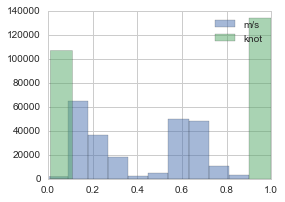

In [5]:
# Detect data stored in knot or m/s
## For data stored originally in knot, the data would cluster at 0.1 and 0.9
df['decimal'] = df.speed % 1 
df.decimal.hist(alpha=0.5, label='m/s', figsize=(4,3))
knot_unit = True if len(df.query('decimal >= 0.2'))/len(df) > 0.3 else False

# Using unit in knot instead of m/s
if knot_unit:
    df['speed']=df['speed']*1.943845
    df['decimal'] = df.speed % 1 
    df.decimal.hist(alpha=0.5,label='knot')
    # need more elaboration, some is not near an integer
    df['speed']=df['speed'].apply(lambda x: int(round(x)))
    plt.legend()

print knot_unit

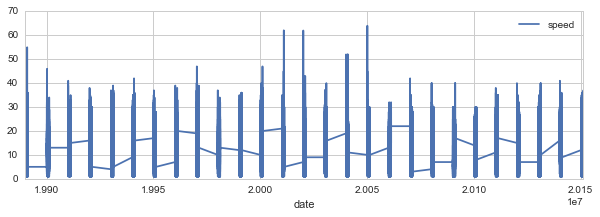

In [6]:
df['speed'].plot(legend=True,figsize=(10,3), grid=True)

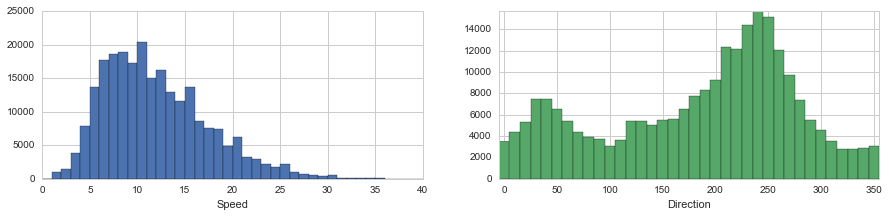

In [7]:
# Notice the gap of the distributions, so futher process needed, as below
plot_speed_and_angle_distribution(df.speed, df.dir)

## 1.3 Data Wrangling

### 1.3.1 Artefacts handling

#### 1.3.1.1 wrong direction record

In [8]:
display(df.query('dir % 10 >= 0.1'))
df = df.query('dir % 10 <= 0.1')

,date,HrMn,type,dir,speed,dir_windrose,decimal
date,,,,,,,
19940613,19940613,950,FM-16,205,8,245,0.969764
19980212,19980212,1750,FM-15,229,12,221,0.051839
19991019,19991019,750,FM-15,359,15,91,0.967607
20000918,20000918,1010,FM-16,342,20,108,0.021604
20010426,20010426,1450,FM-15,179,2,271,0.943845
20020114,20020114,1350,FM-15,151,17,299,0.911451
20020531,20020531,750,FM-15,179,5,271,0.053997
20030716,20030716,1050,FM-15,86,18,4,0.077759
20040309,20040309,1250,FM-15,84,15,6,0.967607


#### 1.3.1.2 sudden increase in speed

,date,HrMn,type,dir,speed,dir_windrose,decimal,incre,incre_reverse
date,,,,,,,,,
20050108,20050108,200,FM-12,250,64,200,0.146885,30.0,30.0
20011001,20011001,1300,FM-12,230,62,220,0.203040,42.0,42.0
20020128,20020128,1700,FM-12,220,62,230,0.203040,32.0,31.0
19890916,19890916,1500,FM-12,20,55,70,0.010814,45.0,49.0
20040927,20040927,1250,FM-15,180,52,270,0.095046,43.0,41.0
20040131,20040131,1900,FM-12,230,52,220,0.483815,24.0,25.0
19970303,19970303,1200,FM-12,210,47,240,0.041049,39.0,42.0
20001030,20001030,800,FM-12,250,47,200,0.041049,11.0,8.0
19900226,19900226,700,FM-12,210,46,240,0.874742,8.0,12.0


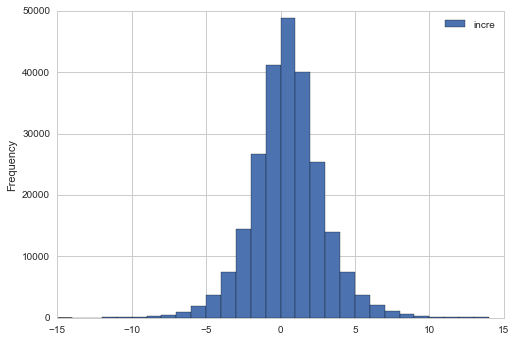

In [9]:
# sudden increse
df['incre'] = df.speed.diff(1)
df['incre'].fillna(0, inplace=True)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'].fillna(0, inplace=True)

display(df.sort_values(by='speed',ascending=False).head(10))
df['incre'].plot(kind='hist', bins=arange(-15, 15), legend=True)

In [10]:
incre_threshold = 20 if knot_unit else 10
print 'sudden increase number', len(df.query('(incre > @incre_threshold )&(incre_reverse > @incre_threshold )'))
df = df.query('(incre < @incre_threshold )|(incre_reverse < @incre_threshold )')

sudden increase number 10


After Simple Aretefacts Handling

In [11]:
# Check the max speed
df.sort_values(by='speed',ascending=False).head(10)

,date,HrMn,type,dir,speed,dir_windrose,decimal,incre,incre_reverse
date,,,,,,,,,
20001030,20001030,800,FM-12,250,47,200,0.041049,11.0,8.0
19900226,19900226,700,FM-12,210,46,240,0.874742,8.0,12.0
20021027,20021027,1200,FM-12,190,43,260,0.958975,3.0,9.0
20021027,20021027,1000,FM-12,210,43,240,0.958975,2.0,3.0
19900226,19900226,400,FM-12,240,43,210,0.958975,11.0,10.0
19900226,19900226,900,FM-12,200,43,250,0.958975,9.0,6.0
20020412,20020412,1900,FM-12,90,43,0,0.764590,21.0,4.0
20040320,20040320,1500,FM-12,210,42,240,0.987052,5.0,8.0
19940914,19940914,2300,FM-12,70,42,20,0.987052,6.0,5.0


#### 1.3.1.3 re-distribute angle, for un-evenly sectored data
For some dataset, the 16 sectors are not record properly,

e.g. the sectors are [0,20,30,50], need to redistribute the angle into 22.5

In [12]:
df['dir'].value_counts().sort_index()

0       3512
10      4364
20      5340
30      7456
40      7460
50      6536
60      5406
70      4392
80      3906
90      3747
100     3070
110     3640
120     5428
130     5370
140     5010
150     5549
160     5595
170     6500
180     7754
190     8290
200     9279
210    12325
220    12194
230    14384
240    15684
250    15160
260    12102
270     9687
280     7423
290     5491
300     4542
310     3522
320     2818
330     2798
340     2887
350     3066
Name: dir, dtype: int64

In [13]:
effective_coloumn = df['dir'].value_counts()[df['dir'].value_counts() > 30].sort_index()

if len(effective_coloumn) == 16:
    # For some dataset, the angle is not evenly distributed, so there is a need to redistribute
    original_angle = list(effective_coloumn.sort_index().index)
    redistributed_angle = linspace(0,360,num=17)[:-1]
    df['dir'].replace(to_replace=original_angle, value=redistributed_angle, inplace=True)
    display(df['dir'].value_counts().sort_index())

SECTOR_LENGTH = 360/len(effective_coloumn)
print len(effective_coloumn), SECTOR_LENGTH

36 10.0


### 1.3.2 Sampling Type Selection

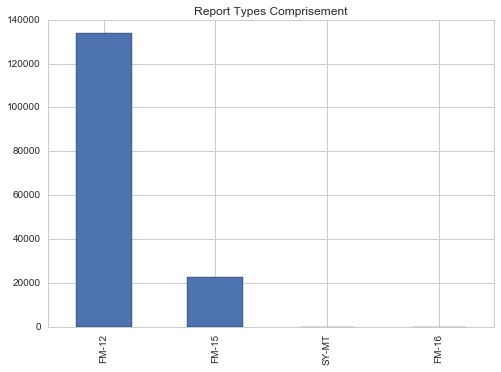

In [14]:
sample_type = df.query('date > 20000000')['type']
sample_type.value_counts().plot(
    kind = 'bar', title = 'Report Types Comprisement')

report_type_most_used = sample_type.value_counts().argmax()
df = df.query("type==@report_type_most_used")

### 1.3.3 Sampling Time Selection

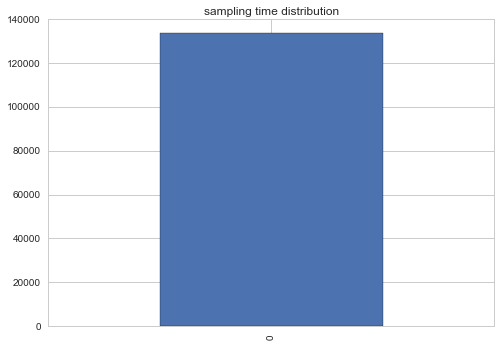

In [15]:
df['sample_time'] = df.HrMn % 100 
sample_time = df.query('date > 20000000')['sample_time']
sample_time.value_counts().plot(
    kind = 'bar', title = 'sampling time distribution')

sampling_time_most_used = sample_time.value_counts().argmax()
df = df.query("sample_time==@sampling_time_most_used")
df.drop(['sample_time'], 1,inplace=True)

In [16]:
df['HrMn'].value_counts().sort_index()

0       9001
100     9098
200     9059
300     9044
400     9020
500     9031
600     8926
700     9021
800     8704
900     8450
1000    8505
1100    8579
1200    8649
1300    8693
1400    8775
1500    8785
1600    9051
1700    9180
1800    9053
1900    9105
2000    9130
2100    9112
2200    9141
2300    9139
Name: HrMn, dtype: int64

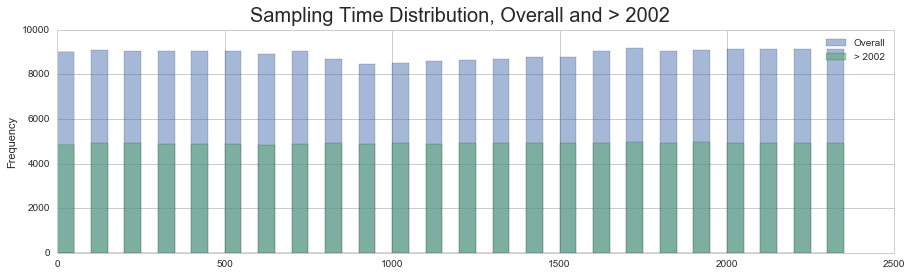

In [17]:
MID_YEAR = int(((min(df.date)+max(df.date))/2 )/10000)
# Ensure data sampled equally
bins=arange(min(df.HrMn), max(df.HrMn) + 100, 50)

df['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='Overall')

df.query('date > @MID_YEAR * 10000')['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' %  MID_YEAR )

plt.suptitle('Sampling Time Distribution, Overall and > %s ' %  MID_YEAR, fontsize = 20)
plt.legend()

### 1.3.4 Re-distribute Direction and Speed
e.g. Dir 50 -> -45 ~ 55, to make KDE result better

In [18]:
DIR_REDISTRIBUTE = 'even'
if DIR_REDISTRIBUTE == 'even':
    DIR_BIN = arange(-5, 360, 10) 
elif DIR_REDISTRIBUTE == 'round_up':
    DIR_BIN = arange(0, 360+10, 10) 

def randomize_angle(df, sector_length = 10):
    if DIR_REDISTRIBUTE == 'even':
        df['dir_ran'] = df['dir'].apply(lambda x: (x + np.random.uniform(-sector_length/2,sector_length/2)))
    else:
        df['dir_ran'] = df['dir'].apply(lambda x: (x + np.random.uniform(0,sector_length)))

    bins=arange(0, 360+10, 5)
    df['dir'].hist(bins=bins, alpha=0.5)
    bins=arange(0, 360+10, 1)
    df['dir_ran'].hist(bins=bins, alpha=0.5,figsize=(15, 4))
    
    df['dir']=df['dir_ran']
    df.drop(['dir_ran'], 1,inplace=True)
    return df

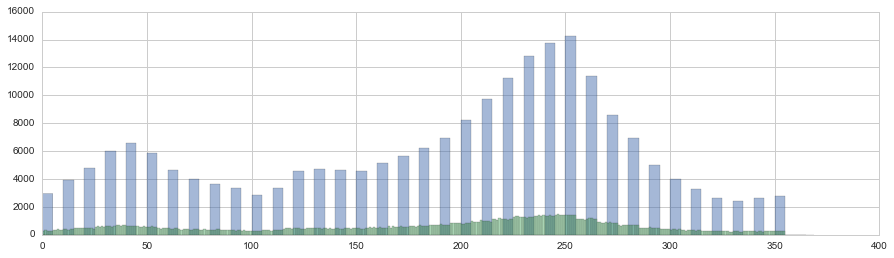

In [19]:
# Randomize the angle degree, to form a better KDE estimation
df = randomize_angle(df, SECTOR_LENGTH)

In [20]:
def randomize_speed(df):
    # Round down speed, need more caution
    df['speed_ran'] = df['speed'].apply(lambda x: (x + np.random.uniform(-1,0)) if x > 0 else x)
    
    max_speed = df.speed.max()
    df['speed'].hist(bins=arange(0, max_speed), alpha=0.5)
    df['speed_ran'].hist(bins=arange(0, max_speed, 0.5), alpha=0.5,figsize=(15, 4))
    
    df['speed']=df['speed_ran']
    df.drop(['speed_ran'], 1,inplace=True)
    return df

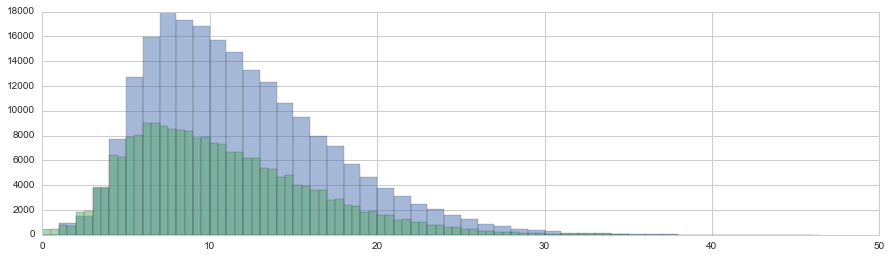

In [21]:
# Each original cell is split between the value, # so the peak is shift left
# e.g. 2 -> (1.5,2), (2,2.5); or 3 -> (2,3)
df = randomize_speed(df)

### 1.3.5 Generate (x,y) from (speed,dir)

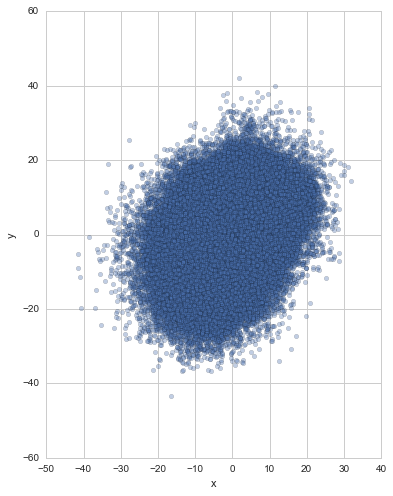

In [22]:
df['x'] = df['speed'] * cos(df['dir'] * pi / 180.0)
df['y'] = df['speed'] * sin(df['dir'] * pi / 180.0)
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
ax.set_aspect('equal')
df.plot(kind='scatter', x='x', y='y', alpha=0.35, ax=ax)

## 1.4 Time Shift Comparison

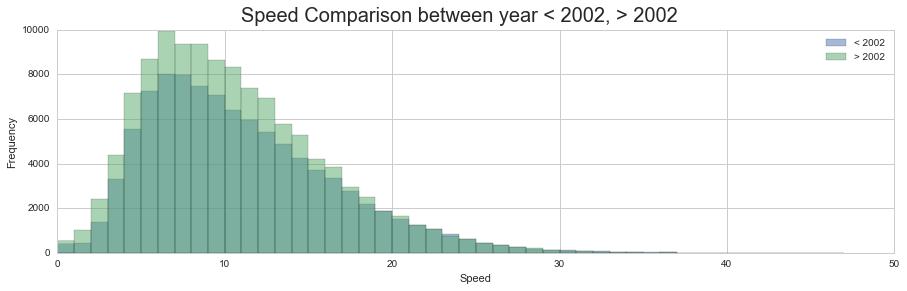

In [23]:
# Comparison between mid_year, looking for: 
# 1. Odd Even Bias
# 2. Time Shift of Wind Speed Distribution
bins = arange(0, max(df.speed) + 1)
df.query('date < @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' % MID_YEAR)

plt.xlabel("Speed")
plt.suptitle('Speed Comparison between year < %s, > %s ' % (MID_YEAR, MID_YEAR), fontsize = 20)
plt.legend()

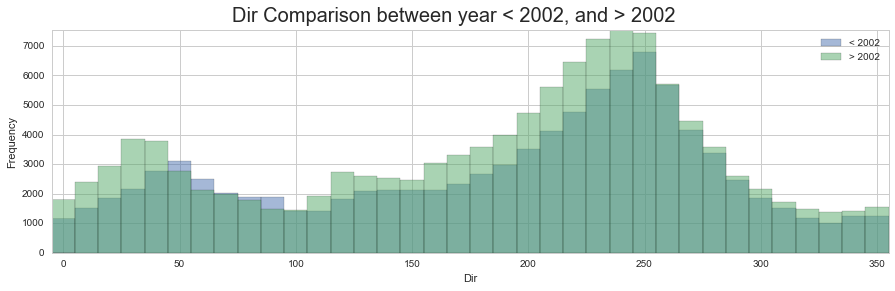

In [24]:
df.query('date < @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,bins=DIR_BIN, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=DIR_BIN, label='> %s' % MID_YEAR)

plt.xlabel("Dir")
plt.suptitle('Dir Comparison between year < %s, and > %s ' % (MID_YEAR, MID_YEAR), fontsize = 20)
plt.axis('tight')
plt.legend()

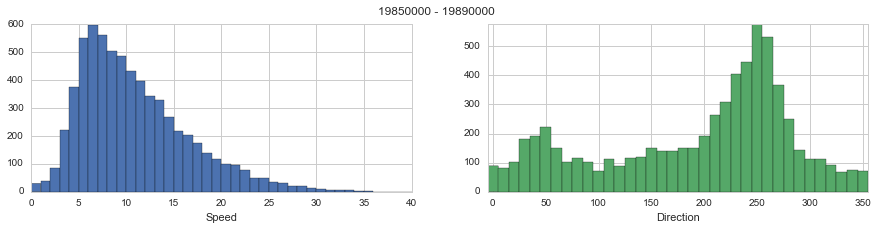

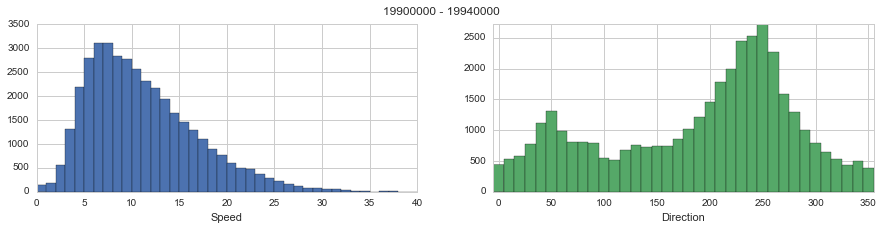

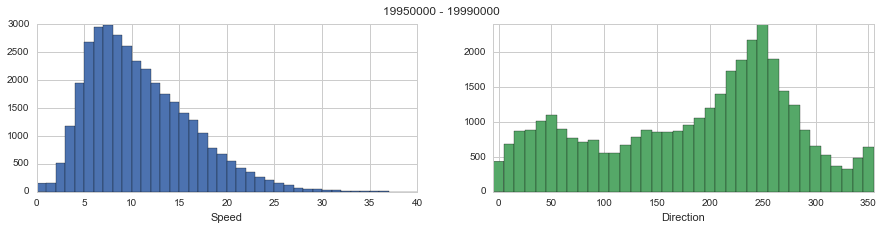

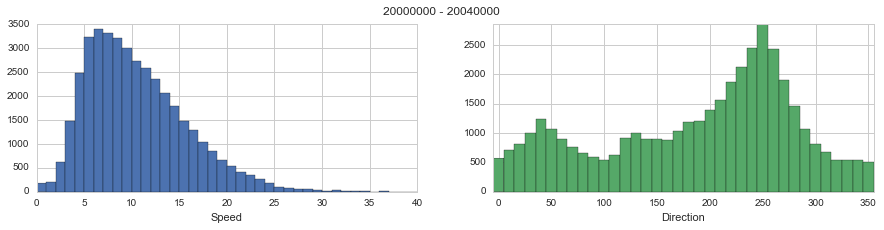

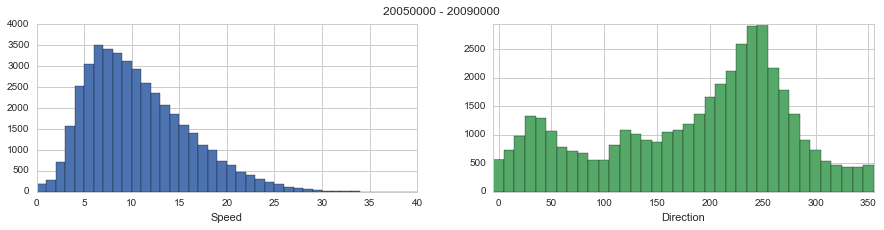

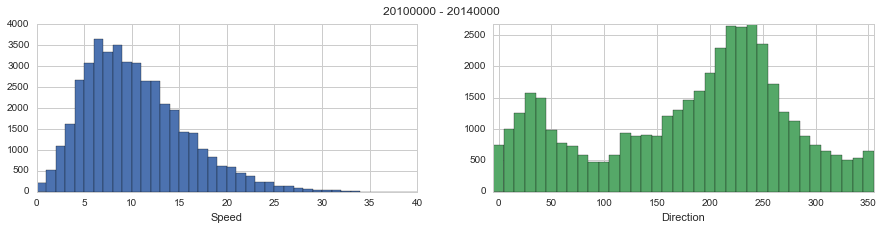

In [25]:
# Inspect the time shift of speed and degree distribution, and odd-even bias
def check_time_shift(df):
    for start_time in xrange(19850000, 20150000, 50000):
        end_time = start_time + 50000 
        sub_df = df.query('(date >= @start_time) & (date < @end_time)')
        if len(sub_df) > 0 :
            title = '%s - %s' %(start_time, end_time-10000)
            plot_speed_and_angle_distribution(sub_df.speed, sub_df.dir, title)
        
check_time_shift(df)

## 1.5 Re-select data, and overview of the clean dataset

In [26]:
## Summery of the data selection
print 'incre_threshold for artefact detect:', incre_threshold
print 'Report type used:', report_type_most_used
print 'Sampling time used:', sampling_time_most_used

df_all_years = df
df = df.query('(date >= 20100000) & (date < 20150000)')
df.describe()

incre_threshold for artefact detect: 20
Report type used: FM-12
Sampling time used: 0


,date,HrMn,dir,speed,dir_windrose,decimal,incre,incre_reverse,x,y
count,4.306500e+04,43065.000000,43065.000000,43065.000000,43065.000000,43065.000000,43065.000000,43065.000000,43065.000000,43065.000000
mean,2.012056e+07,1150.296064,180.961273,10.407431,188.670846,0.550704,-0.188018,-0.133542,-1.994044,-1.876984
std,1.411344e+04,693.692870,92.218012,5.379202,90.562765,0.450547,2.270686,2.401143,8.131294,7.977189
min,2.010010e+07,0.000000,-4.973030,0.008004,0.000000,0.015130,-18.000000,-21.000000,-35.594633,-36.788122
25%,2.011033e+07,500.000000,115.864762,6.421288,110.000000,0.053997,-1.000000,-1.000000,-7.428576,-7.333707
50%,2.012063e+07,1100.000000,203.488472,9.586335,210.000000,0.913609,0.000000,0.000000,-3.111173,-2.133721
75%,2.013093e+07,1800.000000,246.128446,13.504177,250.000000,0.967607,1.000000,1.000000,3.522853,3.647270
max,2.014123e+07,2300.000000,354.937621,40.635974,350.000000,0.997842,17.000000,16.000000,29.294889,28.471659


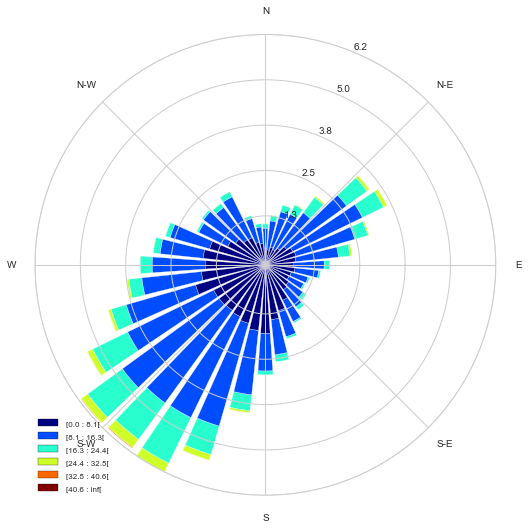

In [27]:
# 90 degree is in east
ax = WindroseAxes.from_ax()
ax.bar(df.dir_windrose, df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36)
ax.set_legend()

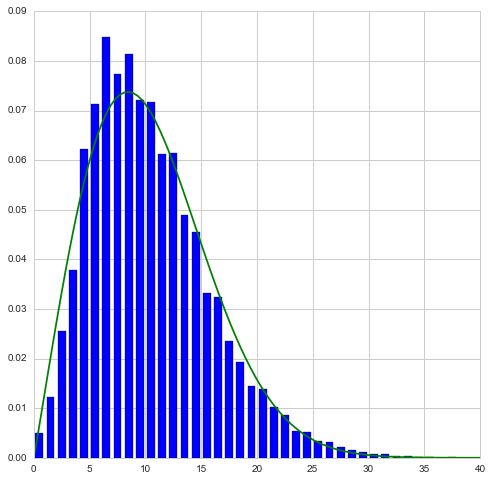

In [28]:
ax, _params = WindAxes.from_ax().pdf(df.speed, 
                                     bins=arange(0, max(df.speed)))
weibull_params = sp.stats.exponweib.fit(df.speed, floc=0, f0=1)

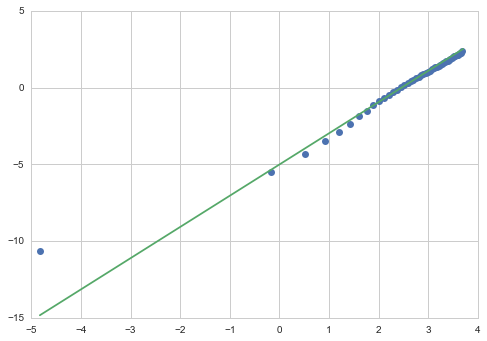

In [29]:
sample = df.speed
ecdf = sm.distributions.ECDF(sample)

x = linspace(min(sample), max(sample))
y = ecdf(x)
plt.plot(log(x), log(-log(1-y)),'o')

w_scale, c_shape = weibull_params[1], weibull_params[3]
qz=exp(-(x/c_shape)**w_scale)
plt.plot(log(x), log(-log(qz)),'-')

# 2. Create input data, i.e. speed_set

In [30]:
# speed_set = array(zip(-df.x, -df.y)) # Adjust the direction to match for Cook's paper
SPEED_SET = array(zip(df.x, df.y))
max_speed = df.speed.max()
NUMBER_OF_GAUSSIAN = 3
FIT_METHOD = 'square_error'
DEFAULT_BANDWDITH = 1.5 if knot_unit else 0.7

In [31]:
FITTING_RANGE = []
fit_limit = ceil(df['speed'].quantile(.95))
plot_limit = ceil(df['speed'].quantile(.975))
fitting_axis_range = arange(-fit_limit, fit_limit+1, 1)
PLOT_AXIS_RANGE = arange(-plot_limit, plot_limit+1, 1)
    
for i in fitting_axis_range:
    for j in fitting_axis_range:
        FITTING_RANGE.append([i,j])
        
print fitting_axis_range

[-21. -20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.
  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.
   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.]


# 3. Kernel Density Estimation

In [32]:
sample = SPEED_SET

In [33]:
# The bandwidth value sometimes would be too radical
from sklearn.grid_search import GridSearchCV

if knot_unit:
    bandwidth_range = arange(0.5,2,0.2)
else:
    bandwidth_range = arange(0.4,1,0.1)

grid = GridSearchCV(neighbors.KernelDensity(),
                    {'bandwidth': bandwidth_range},
                    n_jobs=-1, cv=4) 
grid.fit(sample)
bandwidth = grid.best_params_['bandwidth']

In [34]:
if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH 

kde = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample)

points = FITTING_RANGE
# very slow if the dataset is too large, e.g. 100,000
# kde returns log prob, need to convert it
kde_result = exp(kde.score_samples(points))
print 'bandwidth:', bandwidth, len(kde_result)
print kde_result[:5]

bandwidth: 1.7 1849
[  3.12878757e-05   3.95118926e-05   4.83784054e-05   5.83641843e-05
   6.98454806e-05]


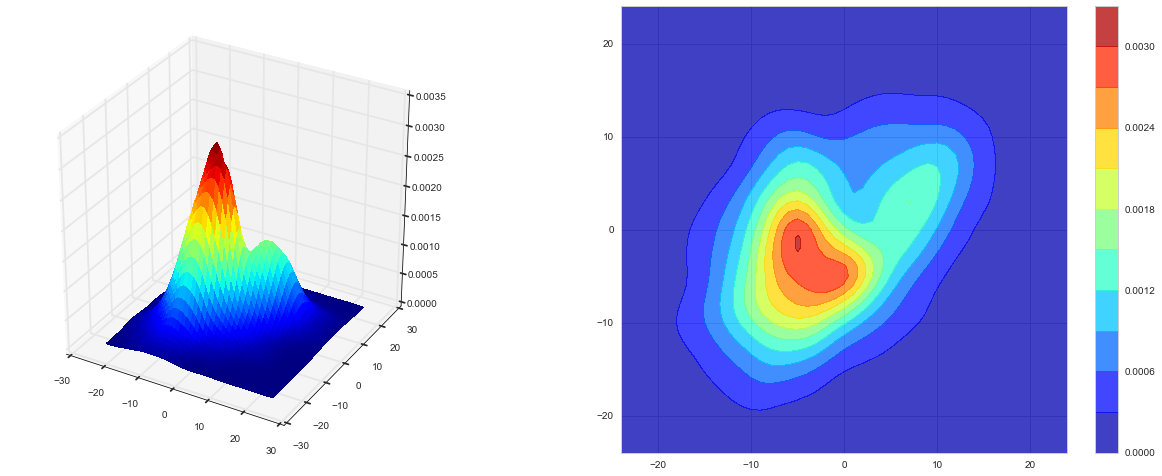

In [35]:
# Plot jPDF
X = Y = PLOT_AXIS_RANGE
# Can't work if pass as generate_Z_from_X_Y(X,Y, exp(kde.score_samples())), need to use lambda
# see http://stackoverflow.com/questions/21035437/passing-a-function-as-an-argument-in-python
kde_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde.score_samples(coords)))

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,kde_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,kde_Z,ax2)

In [36]:
kde_cdf = cdf_from_pdf(kde_result)

# 4. GMM Estimation, using EM algo

In [37]:
sample= SPEED_SET
clf = mixture.GMM(n_components=NUMBER_OF_GAUSSIAN, covariance_type='full')
clf.fit(sample)
print clf.converged_

True


In [38]:
gmm_em_result = read_gmm_em_result(clf)
pretty_print_gmm(gmm_em_result)  

,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.371533,-4.429086,-7.298597,6.444223,6.298289,0.350391
2,0.340849,-5.602238,0.661427,6.257642,7.051774,0.262613
3,0.287618,5.427423,2.118232,7.187745,7.036194,0.447520


GMM Plot Result
0.371533393768 [[-4.42908565 -7.29859655]] [ 5.13287063  7.40608479] -46.8702982901
0.340848616647 [[-5.60223816  0.66142652]] [ 5.63082708  7.56170537] 147.257279024
0.287617989584 [[ 5.42742253  2.11823218]] [ 5.28461624  8.55830179] -46.3632313433


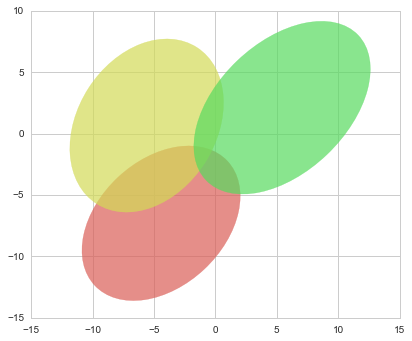

In [39]:
plot_gmm_ellipses(gmm_em_result)

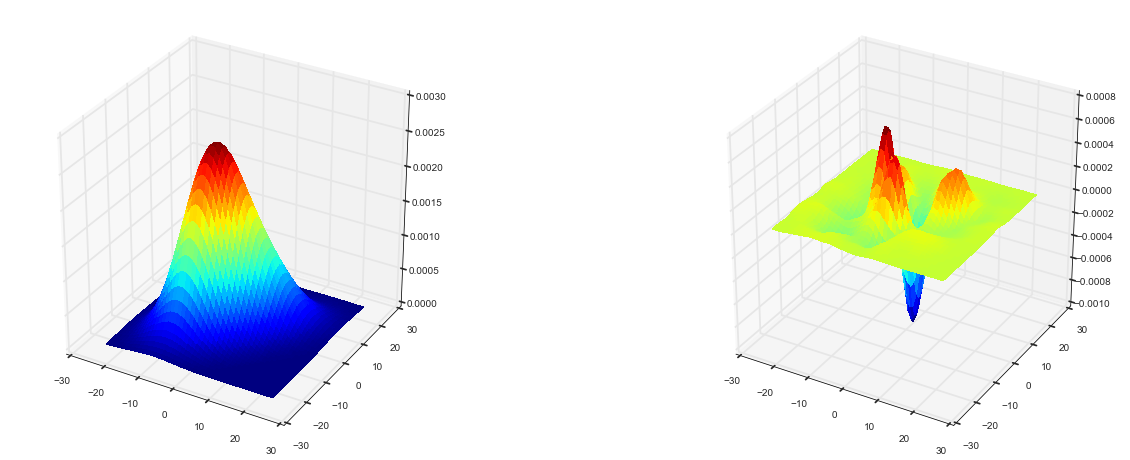

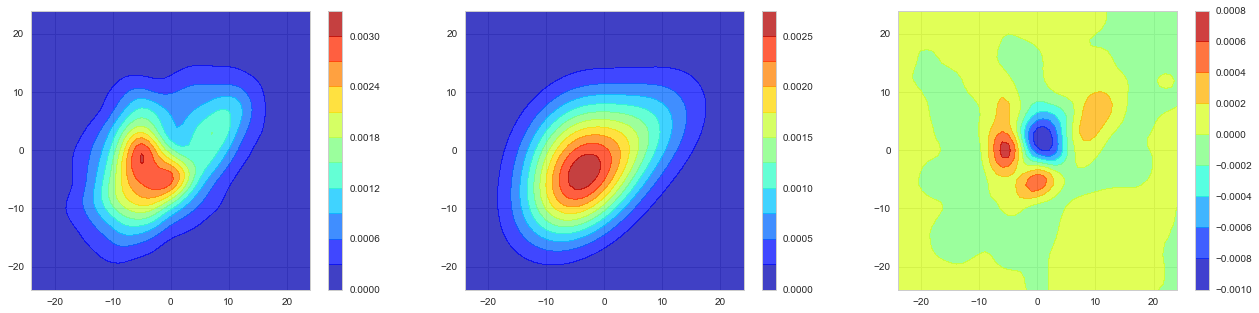

In [40]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(clf.score_samples(coords)[0]))

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = exp(clf.score_samples(points)[0])
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2,projection = '3d')
plot_3d_prob_density(X,Y,residual_Z,ax2)

fig = plt.figure(figsize=(22,5))
ax1 = fig.add_subplot(1,3,1)
plot_2d_prob_density(X,Y,kde_Z,ax1)
ax2 = fig.add_subplot(1,3,2)
plot_2d_prob_density(X,Y,pdf_Z,ax2)
ax3 = fig.add_subplot(1,3,3)
plot_2d_prob_density(X,Y,residual_Z,ax3)

## GMM, EM VS. KDE

In [41]:
points = FITTING_RANGE
gmm_pdf_result = exp(clf.score_samples(points)[0])
# put into Pandas to make it looks better
pretty_pd_display([goodness_of_fit_summary(gmm_pdf_result, kde_result)])

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.044112,0.026959,2.332435e-08,0.050335,0.288199,0.948934


# 5. Least Square Prob Estimation

In [42]:
sample = SPEED_SET
points = FITTING_RANGE

In [43]:
# from GMM,EM 
# GMM format: weight, meanx, meany, sigx, sigy, rho
x0 = gmm_em_result

cons = [
        # sum of every 6th element, which is the fraction of each gaussian
        {'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
        # # limit the width/height ratio of elliplse, optional
        # {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
        # {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},
]

bonds = [(0., 0.99),(-fit_limit, fit_limit),(-fit_limit, fit_limit),
         (0., fit_limit),(0., fit_limit),(-0.99, 0.99)]*int(len(x0)/6)

result = sp.optimize.minimize(
    lambda x0: GMM_fit_score(x0, kde_result, points,FIT_METHOD),
    x0,
    bounds = bonds,
    constraints=cons,
    tol = 0.000000000001,
    options = {"maxiter": 500})
result

     fun: -18.732557632724603
     jac: array([  3.46540093e+00,  -4.76837158e-07,  -7.15255737e-07,
         0.00000000e+00,  -4.76837158e-07,   2.38418579e-07,
         3.46539307e+00,  -2.38418579e-07,   2.38418579e-07,
        -2.38418579e-07,   0.00000000e+00,  -7.15255737e-07,
         3.46539426e+00,  -2.38418579e-07,  -2.38418579e-07,
         4.76837158e-07,   2.38418579e-07,   2.38418579e-07,
         0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 1309
     nit: 65
    njev: 65
  status: 0
 success: True
       x: array([ 0.57360064, -3.18650597, -5.98935716,  7.56010673,  6.00891748,
        0.36925412,  0.17709459,  8.37278311,  6.79411555,  5.0334078 ,
        5.23485164, -0.07973416,  0.24930478, -5.88383828,  1.54264796,
        3.88127253,  6.1894981 , -0.07334765])

## 5.1 GMM Result

In [44]:
# gmm = group_gmm_param_from_gmm_param_array(gmm_em_result, sort_group = True)
gmm = group_gmm_param_from_gmm_param_array(result.x, sort_group = True)
mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
gmm_pdf_result = mixed_model_pdf(points)

pretty_print_gmm(gmm)

,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.573601,-3.186506,-5.989357,7.560107,6.008917,0.369254
2,0.249305,-5.883838,1.542648,3.881273,6.189498,-0.073348
3,0.177095,8.372783,6.794116,5.033408,5.234852,-0.079734


GMM Plot Result
0.573600638153 [[-3.18650597 -5.98935716]] [ 5.17963661  8.1506851 ] -61.0517646144
0.249304776553 [[-5.88383828  1.54264796]] [ 3.86412614  6.20021713] -175.689744918
0.177094585293 [[ 8.37278311  6.79411555]] [ 4.90180948  5.35827673] -148.104990526


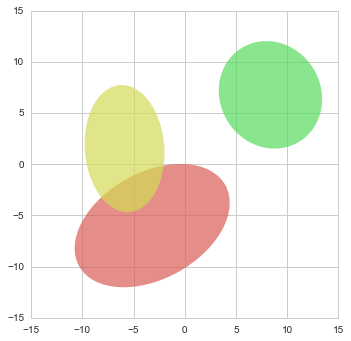

In [45]:
plot_gmm_ellipses(gmm)

## 5.2 Goodness-of-fit statistics

In [46]:
pretty_pd_display([goodness_of_fit_summary(gmm_pdf_result, kde_result)])

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.04456,0.014898,7.320716e-09,0.0282,0.16146,0.983972


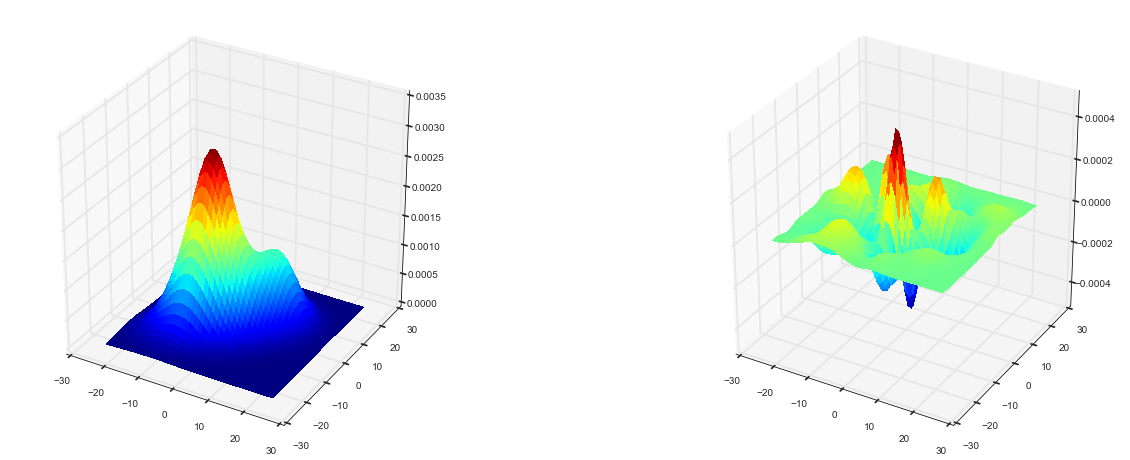

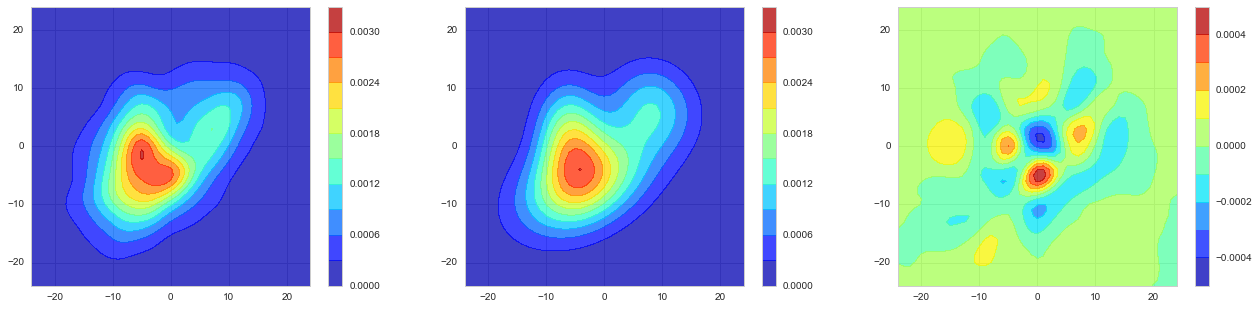

In [47]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = mixed_model_pdf(points)
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2,projection = '3d')
plot_3d_prob_density(X,Y,residual_Z,ax2)

fig = plt.figure(figsize=(22,5))
ax1 = fig.add_subplot(1,3,1)
plot_2d_prob_density(X,Y,kde_Z,ax1)
ax2 = fig.add_subplot(1,3,2)
plot_2d_prob_density(X,Y,pdf_Z,ax2)
ax3 = fig.add_subplot(1,3,3)
plot_2d_prob_density(X,Y,residual_Z,ax3)

In [48]:
def f(V,theta):
    return (mixed_model_pdf([[V*cos(theta),V*sin(theta)]]))*V

x_vals_OEN3_LMSE  = arange(0, max_speed)
y_vals_OEN3_LMSE =[integrate.nquad(f, [[0, x_val],[0, 2*pi]]) for x_val in x_vals_OEN3_LMSE ]

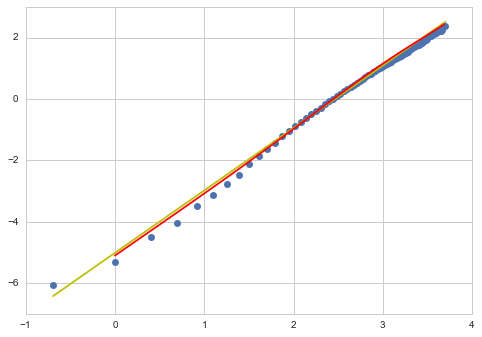

In [49]:
x = arange(0, max_speed, 0.5)

# 1. Plot v-p points, empirical distribution
ecdf = sm.distributions.ECDF(df.speed)
y = ecdf(x)
plt.plot(log(x), log(-log(1-y)),'o')

# 2. Weibull distribution
w_scale, c_shape = weibull_params[1], weibull_params[3]
qz=exp(-(x/c_shape)**w_scale)
plt.plot(log(x), log(-log(qz)),'-', color = 'y')

# 3. OEN3 distribution
x, y_ = x_vals_OEN3_LMSE, y_vals_OEN3_LMSE
y = array(zip(*y_)[0])
plt.plot(log(x), log(-log(1-y)),'-', color = 'r')

plt.show()

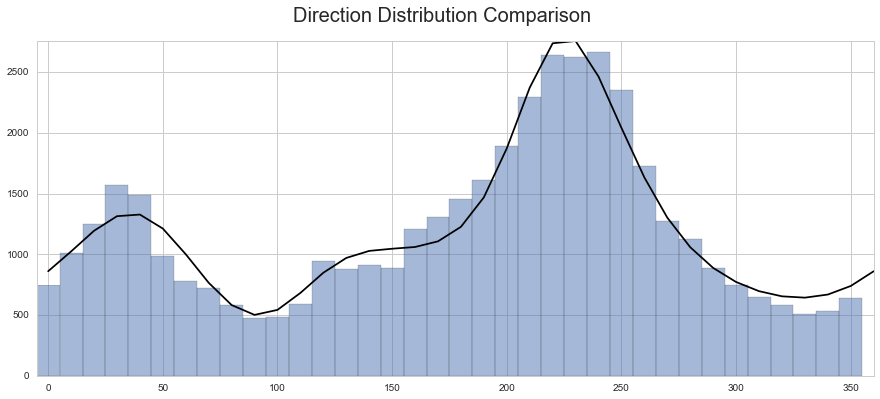

In [50]:
# Calculate Angle Distribution
x_vals = linspace(0,2*pi, num=36+1)
y_vals_ =[integrate.nquad(f, [[0, inf],[x_val-pi/36, x_val+pi/36]]) for x_val in x_vals]

# 1. integrate.nquad returns 2 vaule, result, abserr. Need to abstract the first to plot
# 2. * length of data size, to adjust the plot space
y_vals = array(zip(*y_vals_)[0])*len(df['dir']) 

df['dir'].hist(bins=DIR_BIN, alpha=0.5,figsize=(15, 6))

plt.plot(x_vals/pi*180, y_vals,'-', color='black')
plt.suptitle('Direction Distribution Comparison', fontsize = 20)
plt.axis('tight')
plt.show()

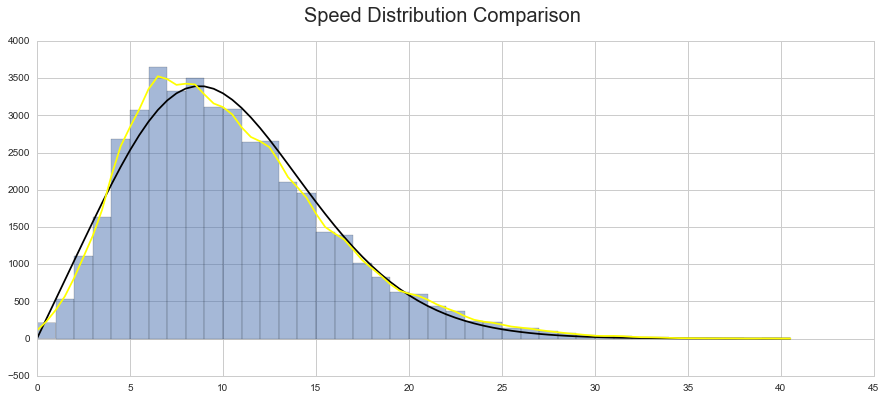

In [51]:
# Calculate Speed Distribution
# 1. GMM Model
x_vals = arange(0, max_speed, 0.5)
y_vals_ =[integrate.nquad(f, [[x_val-0.1, x_val+0.1],[0, 2*pi]]) for x_val in x_vals]
y_vals = array(zip(*y_vals_)[0])*len(df.speed)/0.2
plt.plot(x_vals, y_vals,'-', color='black')

# 2. Observation
df['speed'].hist(bins=arange(0, max_speed), alpha=0.5,figsize=(15, 6))

# 3. 1d KDE
sample = array(df.speed).reshape(-1, 1)
kde_temp = neighbors.KernelDensity(bandwidth=0.5).fit(sample) 
y_vals = [exp(kde_temp.score_samples(x_val))*len(sample) for x_val in x_vals]
plt.plot(x_vals, y_vals,'-', color='yellow')

plt.suptitle('Speed Distribution Comparison', fontsize = 20)
plt.show()

## 5.3 Sectoral Comaprison

In [52]:
# Calculate Speed Distribution
def model_data_comparison(df, original_incre = 10, incre = 10):
    start, end = -original_incre/2 + incre/2, 360
    max_diff_array = []
    max_speed = df.speed.max()
    
    # Find a max count for plotting histogram
    max_count = max_count_for_angles(df, start, end, incre)
    hist_y_axis = [0, max_speed, 0, max_count]
    
    for angle in arange(start, end, incre):
        angle_radian, incre_radian = radians(angle), radians(incre)  
        start_angle, end_angle = angle-incre/2, angle+incre/2
        
        # Select data from observation
        sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)
        direction_prob = integrate.nquad(f, 
                                         [[0, inf],
                                          [angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
        
        # 1. Count Comparison
        # 1.1. Data Histogram
        fig = plt.figure(figsize=(22,4))
        ax1 = fig.add_subplot(1,3,1)        
        sub_df['speed'].hist(bins=arange(0, sub_max_speed), alpha=0.5)
        plt.axis(hist_y_axis)
        
        # 1.2. Model Distribution
        x_vals = linspace(0, sub_max_speed, 20)
        y_vals_ =[integrate.nquad(f, 
                  [[x_val-0.1, x_val+0.1],
                   [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
                  for x_val in x_vals]
        y_vals = array(zip(*y_vals_)[0])/direction_prob[0] * len(sub_df.speed)/0.2
        plt.plot(x_vals, y_vals,'-', color='black')
        
        # 2. CDF Comaprison
        x = linspace(0, sub_max_speed, 20)
        # 2.1. Data's empirical distribution
        ecdf = sm.distributions.ECDF(sub_df.speed)
        y_cdf = ecdf(x)
        
        # 2.2. Model
        y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
             for x_val in x]
        y_gmm = array(zip(*y_)[0])/direction_prob[0]
                
        # 2.3.1. Plot in ordinary axis
        ax3 = fig.add_subplot(1,3,2)
        plt.plot(x, y_cdf,'o')
        plt.plot(x, y_gmm,'-', color = 'r')
        
        # 2.3.2. Weibull plot
        ax4 = fig.add_subplot(1,3,3)
        plt.plot(log(x), log(-log(1-y_cdf)),'o')
        plt.plot(log(x), log(-log(1-y_gmm)),'-', color = 'r')
        
        plt.suptitle('%s (%s - %s) Degree Speed Distribution Comparison' % (angle, start_angle, end_angle), 
                     fontsize = 15)
        plt.show()
        
        diff = abs(y_cdf - y_gmm)
        max_diff_array.append([angle, diff.max(), x[diff.argmax()]])
        print 'data size:', len(sub_df)
        print 'max diff:', diff.max(), ', speed value:', x[diff.argmax()], 'y gmm', y_gmm[diff.argmax()],
    return max_diff_array

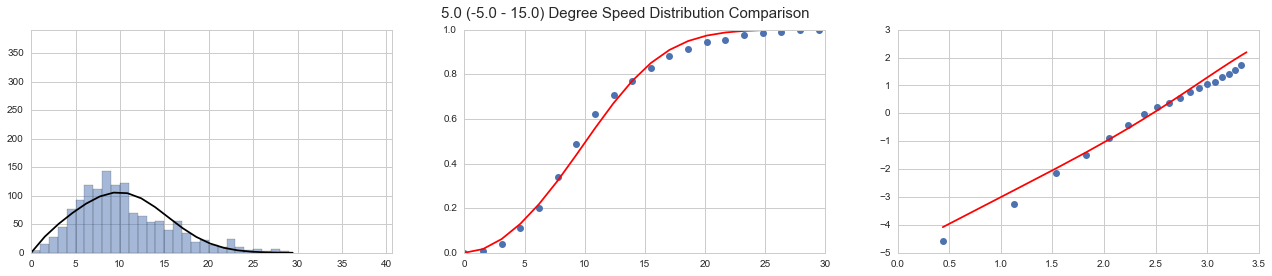

data size: 1375
max diff: 0.0653575915509 , speed value: 10.8457005821 y gmm 0.557187862995

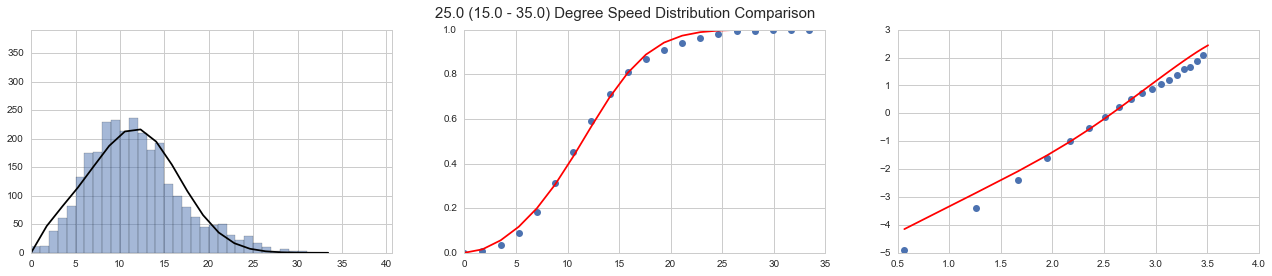

 data size: 2818
max diff: 0.0328625351553 , speed value: 21.1168510258 y gmm 0.972890924084

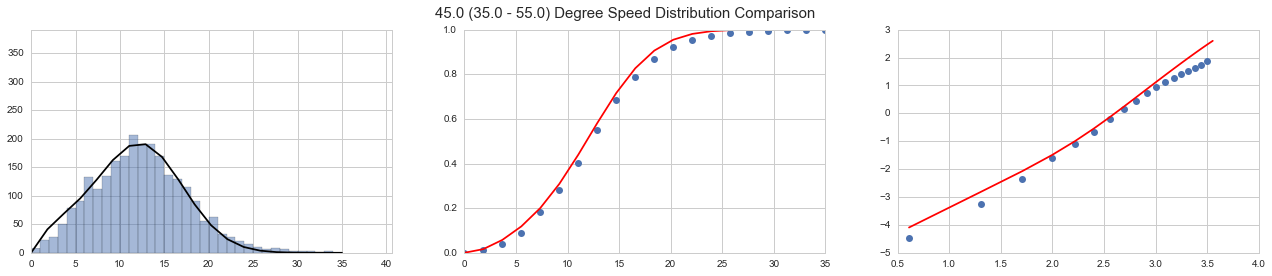

 data size: 2478
max diff: 0.0407948339868 , speed value: 16.5724080873 y gmm 0.826912670952

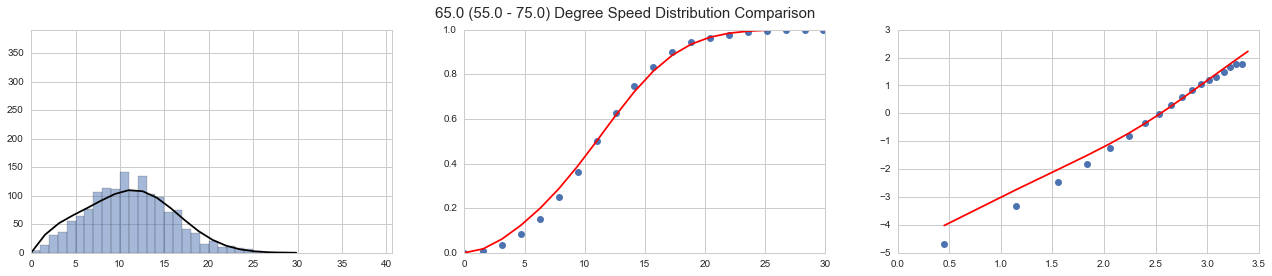

 data size: 1504
max diff: 0.0472493589884 , speed value: 6.28134902232 y gmm 0.198845103669

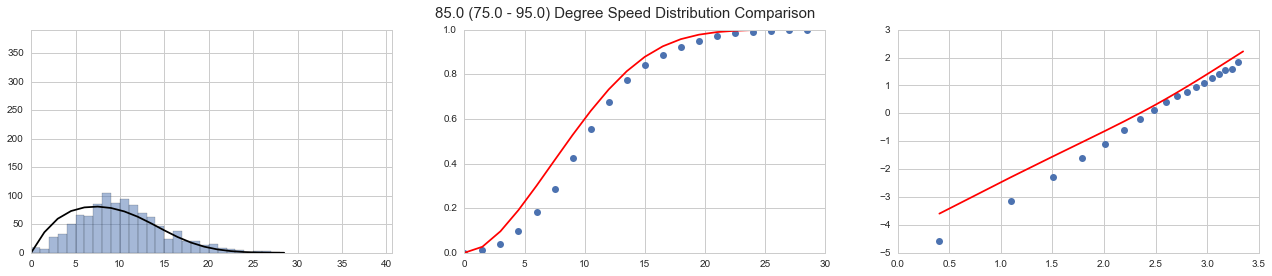

 data size: 1058
max diff: 0.129969486208 , speed value: 7.49531039815 y gmm 0.414468541028

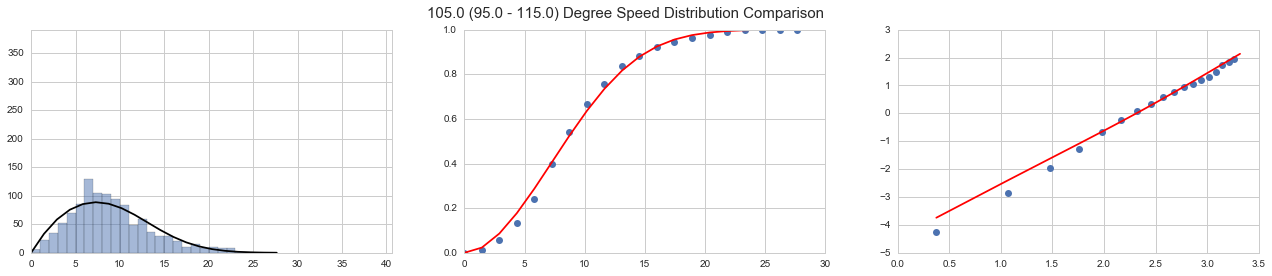

 data size: 1075
max diff: 0.0448633282998 , speed value: 4.36535637968 y gmm 0.177886584114

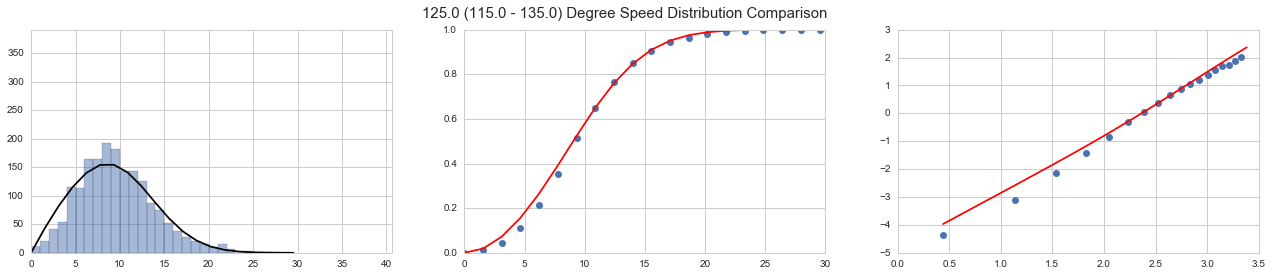

 data size: 1827
max diff: 0.0498199150369 , speed value: 6.21398338835 y gmm 0.26547399276

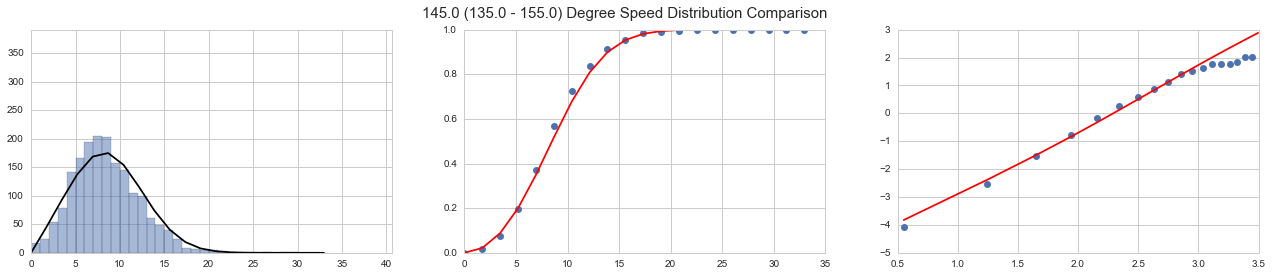

 data size: 1799
max diff: 0.0502235266967 , speed value: 8.67208384313 y gmm 0.516758129779

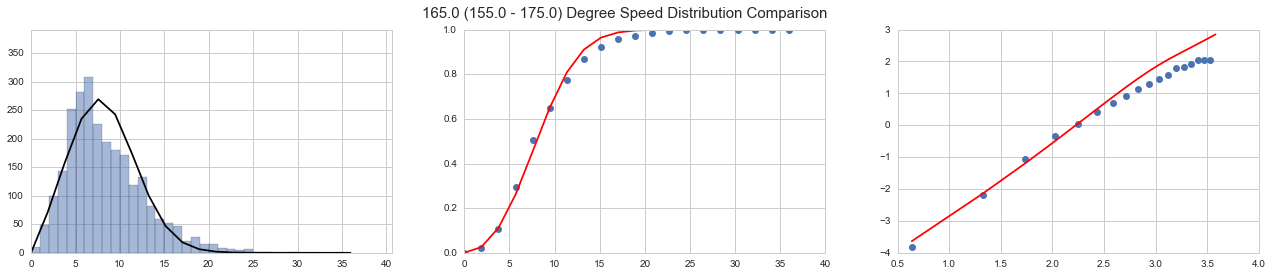

 data size: 2516
max diff: 0.0523708892668 , speed value: 7.56611427769 y gmm 0.45398841121

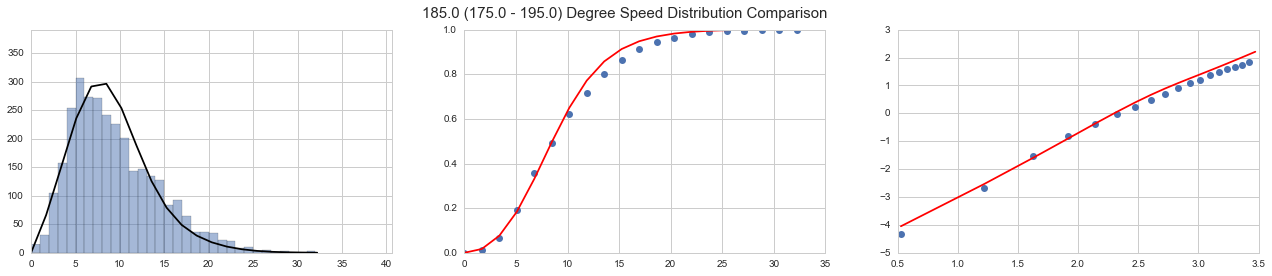

 data size: 3069
max diff: 0.0575298300454 , speed value: 13.5580839403 y gmm 0.857464662238

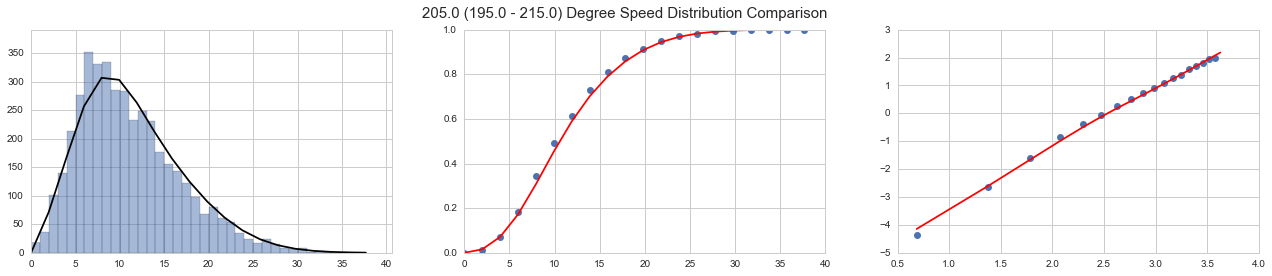

 data size: 4191
max diff: 0.0394506227012 , speed value: 9.9140390038 y gmm 0.453749090971

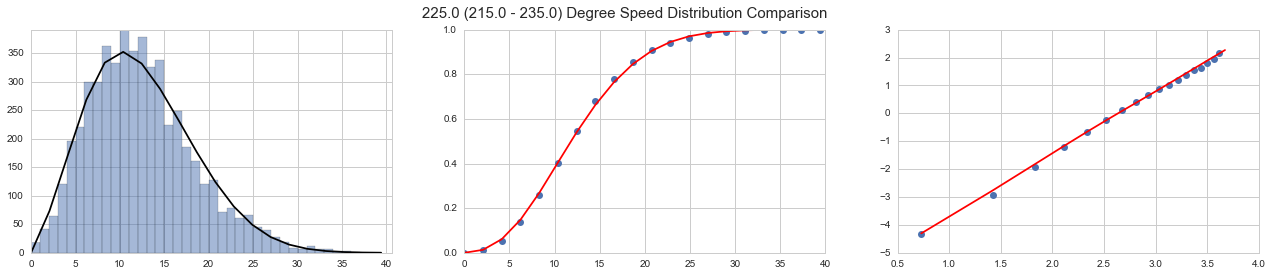

 data size: 5265
max diff: 0.0156736398267 , speed value: 14.5150323168 y gmm 0.662578971759

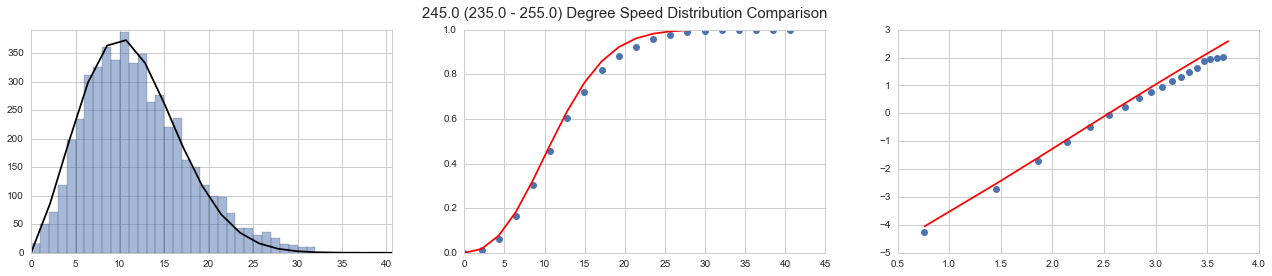

 data size: 5024
max diff: 0.0422068393675 , speed value: 14.9711482904 y gmm 0.762748240641

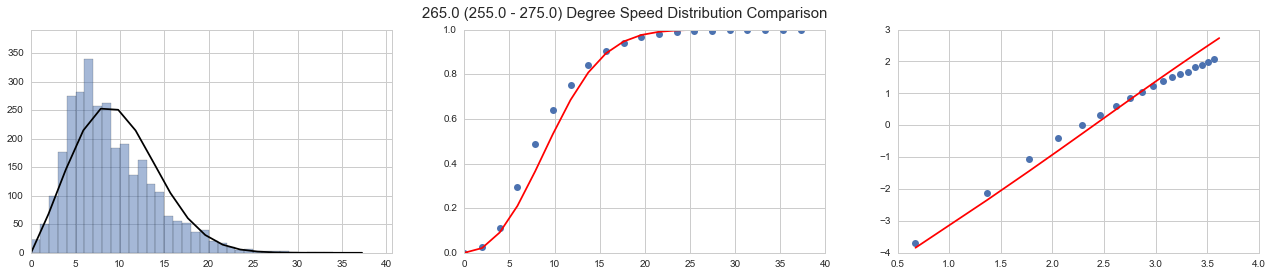

 data size: 3000
max diff: 0.124146801714 , speed value: 7.84223700093 y gmm 0.364853198286

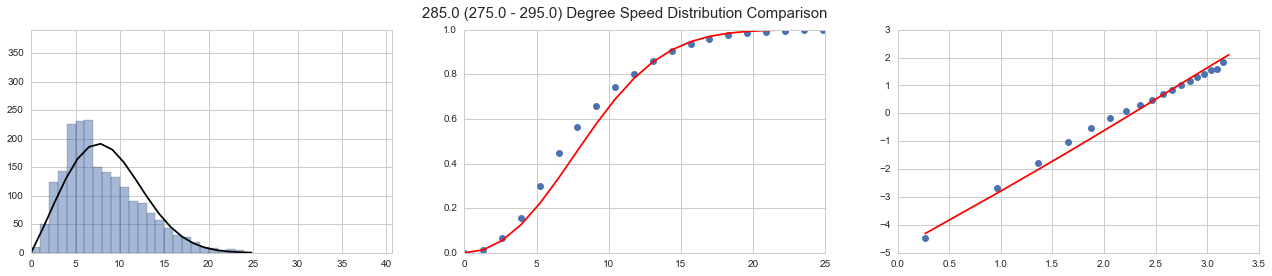

 data size: 2020
max diff: 0.111475599794 , speed value: 6.52804421759 y gmm 0.335059053672

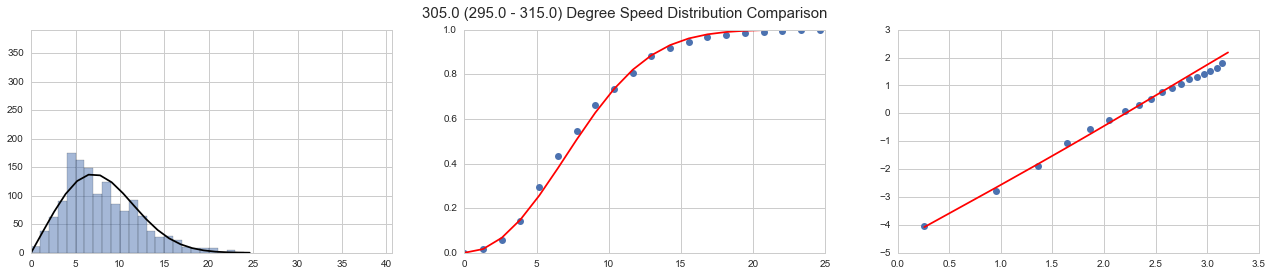

 data size: 1394
max diff: 0.0543597394011 , speed value: 6.47544964971 y gmm 0.378925769925

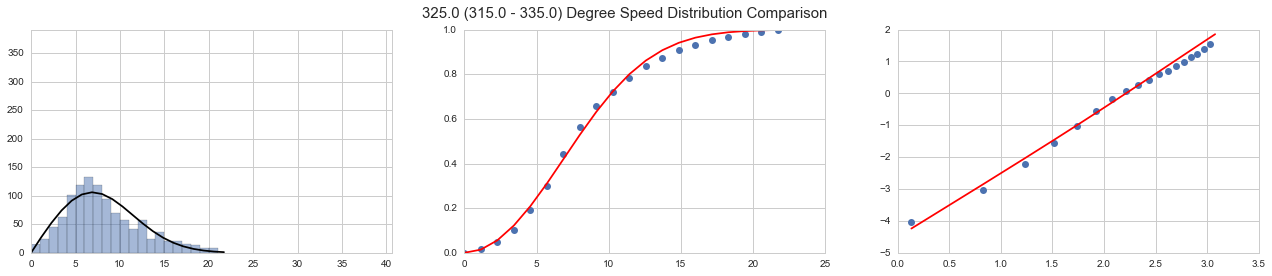

 data size: 1097
max diff: 0.0372462652185 , speed value: 13.711316338 y gmm 0.907802327206

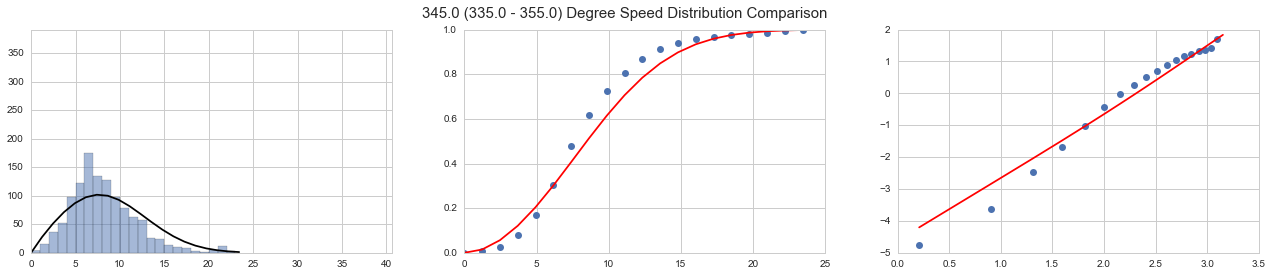

 data size: 1175
max diff: 0.112545981255 , speed value: 9.85987761028 y gmm 0.614262529383


In [53]:
if len(effective_coloumn) == 16:
    max_diff_array = model_data_comparison(df, SECTOR_LENGTH, 22.5)
else: 
    max_diff_array = model_data_comparison(df, SECTOR_LENGTH, 20)

### 5.3.1 Variance over the years

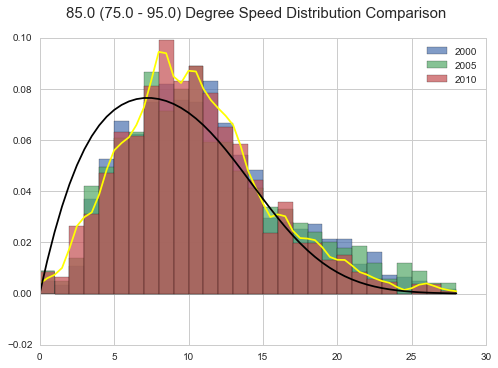

In [54]:
max_diff_element = max(max_diff_array, key=lambda x: x[1])
angle =  max_diff_angle = max_diff_element[0]
incre = 20

# Select data from observation
start_angle, end_angle = angle-incre/2, angle+incre/2
angle_radian, incre_radian = radians(angle), radians(incre)  
sub_df, max_speed = select_df_by_angle(df, start_angle, end_angle)

x_vals = arange(0, max_speed, 0.5)

# 1. 1d KDE 
sample = array(sub_df.speed).reshape(-1, 1)
sub_kde = neighbors.KernelDensity(bandwidth=0.5).fit(sample) 
y_vals = [exp(sub_kde.score_samples(x_val))
          for x_val in x_vals]
plt.plot(x_vals, y_vals,'-', color='yellow')

# 2. GMM
y_vals_ =[integrate.nquad(f, [[x_val-0.1, x_val+0.1],
                              [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_val in x_vals]
direction_prob = integrate.nquad(f, [[0, inf],
                                     [angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_vals = array(zip(*y_vals_)[0])/direction_prob[0] /0.2
plt.plot(x_vals, y_vals,'-', color='black')

for start_time in xrange(20000000, 20150000, 50000):
    end_time = start_time + 50000 
    df_other_years = df_all_years.query('(date >= @start_time) & (date < @end_time)')
    df_other_years_at_angle, _ = select_df_by_angle(df_other_years, start_angle, end_angle)
    if len(df_other_years) > 0 :
        df_other_years_at_angle['speed'].hist(bins=arange(0, max_speed), 
                                              normed=True,alpha=0.7,
                                              label = str(int(start_time/10000)))

plt.suptitle('%s (%s - %s) Degree Speed Distribution Comparison' % (angle, start_angle, end_angle), 
             fontsize = 15)
plt.legend()
plt.show()

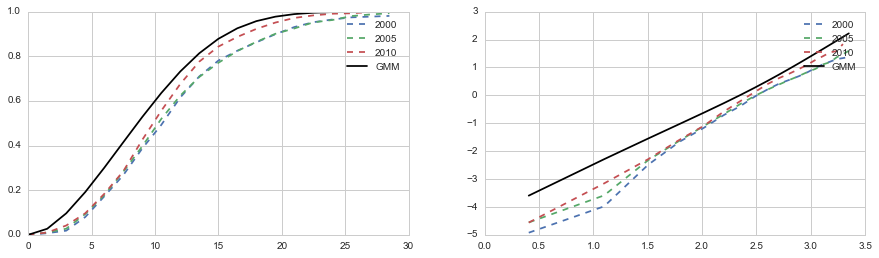

In [55]:
fig = plt.figure(figsize=(15,4))

x = linspace(0, max_speed, 20)
for start_time in xrange(20000000, 20150000, 50000):
    end_time = start_time + 50000 
    df_other_years = df_all_years.query('(date >= @start_time) & (date < @end_time)')
    df_other_years_at_angle, _ = select_df_by_angle(df_other_years, start_angle, end_angle)
    if len(df_other_years_at_angle) > 0 :
        
        sample = df_other_years_at_angle.speed
        ecdf = sm.distributions.ECDF(sample)
        y_cdf = ecdf(x)

        ax1 = fig.add_subplot(1,2,1) 
        plt.plot(x, y_cdf,'--', label = str(int(start_time/10000)))

        ax3 = fig.add_subplot(1,2,2) 
        plt.plot(log(x), log(-log(1-y_cdf)),'--', label = str(int(start_time/10000)))
       
y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm = array(zip(*y_)[0])/direction_prob[0]

ax1 = fig.add_subplot(1,2,1) 
plt.plot(x, y_gmm,'-', color = 'black', label = 'GMM')
plt.legend()

ax3 = fig.add_subplot(1,2,2) 
plt.plot(log(x), log(-log(1-y_gmm)),'-', color = 'black',label = 'GMM')
plt.legend()

### 5.3.2 Bootstrap, to see the variance of each sector

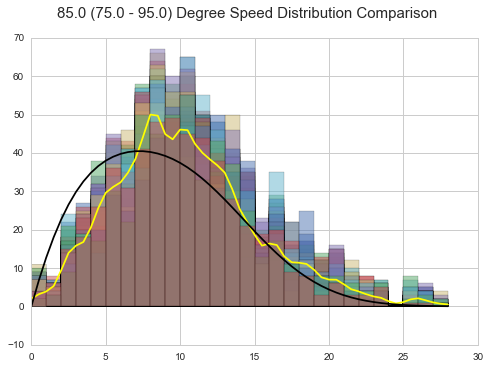

In [56]:
FRACTION = 0.5 

x_vals = arange(0, max_speed, 0.5)

# 1. 1d KDE 
sample = array(sub_df.speed).reshape(-1, 1)
sub_kde = neighbors.KernelDensity(bandwidth=0.5).fit(sample) 
y_vals = [exp(sub_kde.score_samples(x_val))*len(sub_df.speed)*FRACTION
          for x_val in x_vals]
plt.plot(x_vals, y_vals,'-', color='yellow')

#2. GMM
y_vals_ =[integrate.nquad(f, [[x_val-0.1, x_val+0.1],
                              [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_val in x_vals]
direction_prob = integrate.nquad(f, [[0, inf],
                                     [angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_vals = array(zip(*y_vals_)[0])/direction_prob[0]/0.2 *len(sub_df.speed)*FRACTION
plt.plot(x_vals, y_vals,'-', color='black')

bins = arange(0, max_speed, 1)
for i in xrange(1,100):
    sub_df_resampled = sub_df.sample(frac=FRACTION, replace=True)
    sub_df_resampled['speed'].hist(bins=bins, alpha=0.5)

plt.suptitle('%s (%s - %s) Degree Speed Distribution Comparison' % (angle, start_angle, end_angle), 
             fontsize = 15)

0.128257460164 5.99624831852 0.300280144474


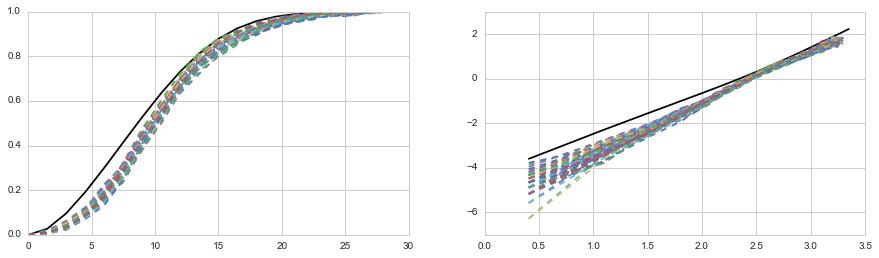

In [57]:
fig = plt.figure(figsize=(15,4))

x = linspace(0, max_speed, 20)
y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm = array(zip(*y_)[0])/direction_prob[0]

ax1 = fig.add_subplot(1,2,1) 
plt.plot(x, y_gmm,'-', color = 'black')

ax3 = fig.add_subplot(1,2,2) 
plt.plot(log(x), log(-log(1-y_gmm)),'-', color = 'black')

for i in xrange(1,100):
    sub_df_resampled = sub_df.sample(frac=FRACTION, replace=True)
    
    sample = sub_df_resampled.speed
    ecdf = sm.distributions.ECDF(sample)
    y_cdf = ecdf(x)

    ax1 = fig.add_subplot(1,2,1) 
    plt.plot(x, y_cdf,'--')

    ax3 = fig.add_subplot(1,2,2) 
    plt.plot(log(x), log(-log(1-y_cdf)),'--')
    
diff = abs(y_cdf - y_gmm)
print diff.max(), x[diff.argmax()], y_gmm[diff.argmax()]

# 6. Variance of results & Cross Validation

In [58]:
from sklearn.cross_validation import train_test_split, KFold

if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH    
    
points = FITTING_RANGE
    
def fit_gmm(df, number_of_gaussian = 3, fit_method = 'square_error'):
    # 1. Create Input, speed_set
    sample = sub_speed_set = array(zip(df.x, df.y))
    points = FITTING_RANGE
    
    # 2. KDE + EM fitting
    kde = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
    kde_result = exp(kde.score_samples(points))
    
    clf = mixture.GMM(n_components=number_of_gaussian, covariance_type='full')
    clf.fit(sample)
    gmm_em_result = read_gmm_em_result(clf)
        
    # 3. GMM fitting
    x0 = gmm_em_result
    bonds = [(0., 0.99),(-fit_limit, fit_limit),
             (-fit_limit, fit_limit),(0., fit_limit),(0., fit_limit),(-0.99, 0.99)]*int(len(x0)/6)
    cons = [{'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
#             {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
#             {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},
           ]
 
    result = sp.optimize.minimize(
        lambda x0: GMM_fit_score(x0, kde_result, points, method=fit_method),
        x0,
        bounds = bonds,
        constraints = cons,
        tol = 0.000000000001,
        options = {"maxiter": 500})  
    
    # 4. Returns
    gmm = group_gmm_param_from_gmm_param_array(result.x)  
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    gmm_pdf_result = mixed_model_pdf(points)
    
    return {
        'gmm' : gmm,
        'kde_clf': kde,
        'kde_result': kde_result,
        'gmm_pdf_result': gmm_pdf_result,
        'number_of_iteration': result.nit,
    }

## 6.1 Variance of the Result

,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.573295,-3.213913,-5.986708,7.601196,6.026891,0.380793
2,0.255251,-5.832097,1.457605,3.921375,6.391127,-0.079360
3,0.171454,8.297771,6.796096,5.035147,5.142859,-0.081520


GMM Plot Result
0.573294886411 [[-3.21391253 -5.98670761]] [ 5.15477148  8.21765918] -60.7944251197
0.255250883283 [[-5.83209652  1.45760491]] [ 3.90164128  6.40319345] -175.561586636
0.171454230306 [[ 8.29777116  6.7960962 ]] [ 4.87030484  5.29922956] -142.278062033


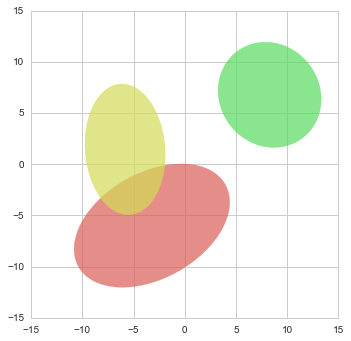

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.05326,0.015521,8.043546e-09,0.029519,0.169235,0.982475


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.553992,-3.010425,-6.131443,7.600642,5.949519,0.400949
2,0.270661,-5.897183,1.340311,3.981249,6.206944,-0.035249
3,0.175347,8.351143,6.767505,4.963154,5.125514,-0.094271


GMM Plot Result
0.553991809788 [[-3.01042525 -6.13144271]] [ 5.02782761  8.23938548] -60.8369326933
0.270661385599 [[-5.89718311  1.34031145]] [ 3.97705093  6.20963515] -177.803388106
0.175346804613 [[ 8.3511429   6.76750495]] [ 4.78724948  5.2901827 ] -144.427824667


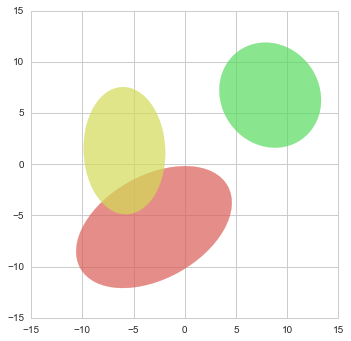

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.051815,0.016828,7.367416e-09,0.028833,0.162062,0.98394


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.581242,-3.278434,-5.847893,7.564442,6.011875,0.350540
2,0.241500,-5.731957,1.400951,3.851513,6.355670,-0.138026
3,0.177258,8.278085,6.977408,5.213699,5.279721,-0.082316


GMM Plot Result
0.581242084951 [[-3.27843426 -5.84789253]] [ 5.25086314  8.11121842] -61.7346786481
0.241500305693 [[-5.73195702  1.40095129]] [ 3.79408388  6.39011842] -172.595695255
0.177257609356 [[ 8.27808451  6.97740763]] [ 5.02362789  5.4608855 ] -139.345872395


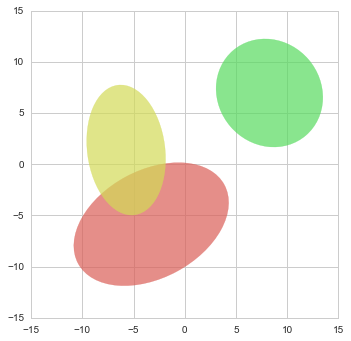

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.041706,0.012867,6.983443e-09,0.027488,0.157576,0.98488


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.571133,-3.418087,-6.058483,7.523440,6.007375,0.335208
2,0.248552,-5.661435,1.527827,3.855508,6.323335,-0.093012
3,0.180315,8.424197,6.364177,4.806089,5.406502,-0.015093


GMM Plot Result
0.571132669857 [[-3.41808677 -6.05848268]] [ 5.296205    8.03995775] -62.0492241986
0.248552202378 [[-5.66143512  1.52782668]] [ 3.82908369  6.33937061] -174.882922179
0.180315127765 [[ 8.42419655  6.36417671]] [ 4.80348965  5.40881141] -176.355199481


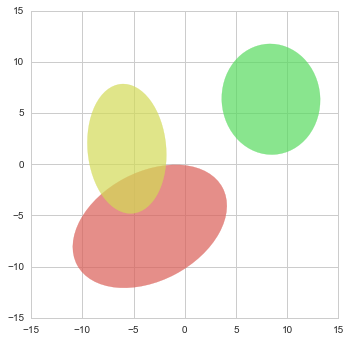

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.043373,0.0152,7.619257e-09,0.028859,0.164788,0.98343


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.568116,-2.951168,-5.893087,7.762654,6.101039,0.407813
2,0.264603,-5.796590,1.336759,4.007484,6.278442,-0.101651
3,0.167281,8.268877,7.077742,4.986833,5.151976,-0.101823


GMM Plot Result
0.568115533905 [[-2.9511683  -5.89308684]] [ 5.12375986  8.43970079] -60.4049437191
0.264603122903 [[-5.79659037  1.33675853]] [ 3.97280397  6.30044387] -173.824050122
0.167281343192 [[ 8.26887666  7.07774237]] [ 4.79155035  5.33407985] -143.872815877


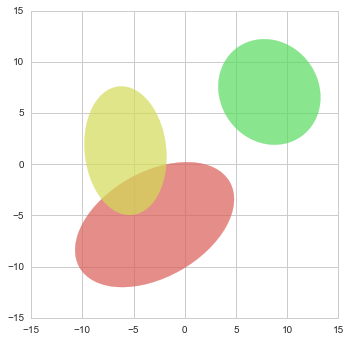

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.049424,0.014839,7.400980e-09,0.028061,0.162389,0.983738


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.585887,-3.466973,-5.956006,7.440043,6.139759,0.338261
2,0.238301,-5.880035,1.922438,3.924241,6.168932,-0.058633
3,0.175811,8.607442,6.384981,4.755817,5.357922,-0.068196


GMM Plot Result
0.585887373906 [[-3.466973   -5.95600564]] [ 5.35996356  8.02007949] -59.8713269474
0.238301213862 [[-5.88003473  1.922438  ]] [ 3.91293812  6.17610733] -176.429018258
0.175811412232 [[ 8.60744219  6.38498076]] [ 4.70710232  5.40076923] -165.142743574


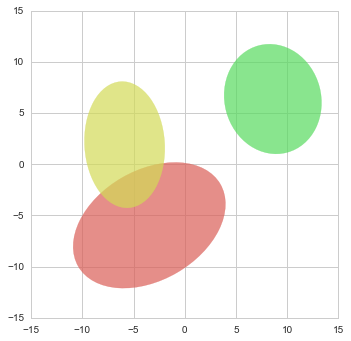

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.038762,0.016394,7.525547e-09,0.029182,0.163812,0.983251


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.607391,-2.978961,-5.740518,7.510629,6.005118,0.375173
2,0.214916,-6.075218,2.158330,3.676919,5.742972,-0.036013
3,0.177693,8.216520,7.157208,5.273674,5.166816,-0.105687


GMM Plot Result
0.607390826382 [[-2.97896074 -5.74051794]] [ 5.14696145  8.12279398] -60.5084511689
0.214916205331 [[-6.07521808  2.15833007]] [ 3.67288193  5.74555502] -177.7657289
0.177692968287 [[ 8.21651993  7.15720828]] [ 4.93158368  5.49427976] -129.518651504


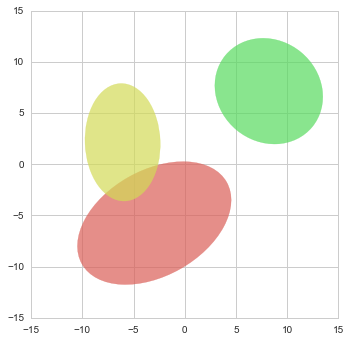

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.054912,0.015583,7.844869e-09,0.029246,0.167162,0.98269


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.564375,-3.048463,-5.974732,7.590929,5.934998,0.398258
2,0.257968,-5.953184,1.484763,3.871126,6.063709,-0.049687
3,0.177657,8.365074,7.003454,5.333788,5.072748,-0.089593


GMM Plot Result
0.564374987467 [[-3.04846277 -5.97473237]] [ 5.02718876  8.22032671] -60.985474499
0.257967797475 [[-5.95318389  1.48476348]] [ 3.86307446  6.06884121] -176.943853006
0.177657215059 [[ 8.36507368  7.00345441]] [ 4.93075278  5.4653216 ] -120.368816121


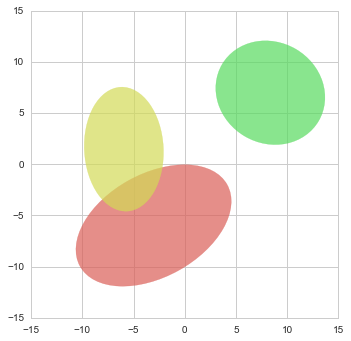

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.048764,0.014787,7.439289e-09,0.028315,0.162755,0.983921


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.573034,-3.231654,-6.009640,7.458468,6.007129,0.357455
2,0.247112,-5.939403,1.697446,3.842437,6.217098,-0.054682
3,0.179854,8.295817,6.832346,5.121955,5.250330,-0.088099


GMM Plot Result
0.573033886125 [[-3.23165414 -6.00964   ]] [ 5.20539272  8.03854631] -60.6944280628
0.247111721496 [[-5.93940275  1.69744563]] [ 3.83315837  6.22282277] -176.87923279
0.17985439238 [[ 8.29581736  6.83234634]] [ 4.94360893  5.41859031] -142.848117262


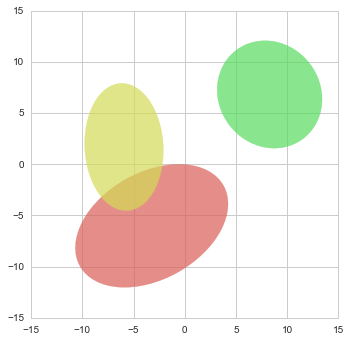

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.047538,0.014396,7.245756e-09,0.028369,0.160667,0.984063


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.566376,-3.204426,-6.008369,7.510291,5.908392,0.379930
2,0.253036,-5.970586,1.619525,3.904605,6.234926,-0.036910
3,0.180588,8.267399,6.760687,4.899991,5.320225,-0.058043


GMM Plot Result
0.566375880614 [[-3.20442638 -6.00836892]] [ 5.06590473  8.10247932] -61.2589081239
0.253035661823 [[-5.97058637  1.61952493]] [ 3.90023309  6.23766148] -177.825262592
0.180588457563 [[ 8.26739913  6.76068659]] [ 4.8508102   5.36510413] -162.415293972


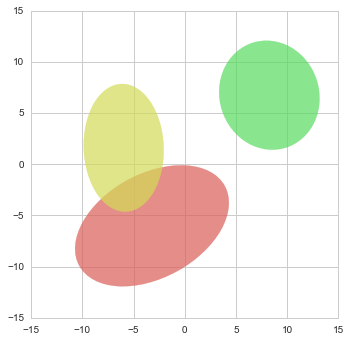

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.050126,0.014436,7.814100e-09,0.02932,0.166691,0.982989


In [59]:
for i in range(10):
    df_resampled = df.sample(frac=1, replace=True)
    result = fit_gmm(df_resampled, NUMBER_OF_GAUSSIAN, fit_method = FIT_METHOD)
    display(pretty_print_gmm(result['gmm']))
    plot_gmm_ellipses(result['gmm'])
    pretty_pd_display([goodness_of_fit_summary(result['gmm_pdf_result'], result['kde_result'])])

## 6.2 Cross validation, to select the number of Gaussian

In [60]:
## 5-fold cross validation
gaussian_number_range = arange(1,7)
CV_result_train_all,CV_result_test_all =[],[]
number_of_fold = 4
print 'Number of train/test dataset', len(df)*(number_of_fold-1)/number_of_fold, len(df)/number_of_fold

for number_of_gaussian in gaussian_number_range:
    print '  '
    print 'Number of gaussian', number_of_gaussian
    
    kf = KFold(len(df), n_folds=number_of_fold, shuffle=True) 

    CV_result_train, CV_result_test = [],[]
    for train_index, test_index in kf:
        sub_df, sub_df_test = df.iloc[train_index], df.iloc[test_index]

        # 1. Train
        result = fit_gmm(sub_df, number_of_gaussian, fit_method = FIT_METHOD)
        gmm_pdf_result_train = result['gmm_pdf_result']
        kde_result_train = result['kde_result']

        # 2. Validate
        # GMM from Train - KDE from Test
        sample = array(zip(sub_df_test.x, sub_df_test.y))
        kde_test = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
        kde_result_test = exp(kde_test.score_samples(points))

        gof_train = goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_train,)
        gof_test =  goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_test,)
                
        CV_result_train.append(gof_train)
        CV_result_test.append(gof_test)
        
    CV_result_train_all.append(CV_result_train)
    CV_result_test_all.append(CV_result_test)
    
    print 'Train'
    pretty_pd_display(CV_result_train)
    print 'Test'
    pretty_pd_display(CV_result_test)

Number of train/test dataset 32298.75 10766.25
  
Number of gaussian 1
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.073448,0.046512,4.680616e-08,0.070767,0.408216,0.897989
1,0.070391,0.045096,4.497609e-08,0.069863,0.400250,0.901935
2,0.074036,0.047214,4.737391e-08,0.072235,0.410781,0.895942
3,0.073954,0.046889,4.616798e-08,0.070863,0.405416,0.898475


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.074843,0.045107,4.651679e-08,0.072740,0.407137,0.896997
1,0.086806,0.042841,5.036469e-08,0.073960,0.423343,0.888712
2,0.072963,0.043548,4.295740e-08,0.066633,0.390972,0.907203
3,0.076994,0.054214,4.991149e-08,0.072859,0.421753,0.892518


  
Number of gaussian 2
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.062095,0.022988,1.416590e-08,0.039803,0.224613,0.968815
1,0.057275,0.022100,1.407407e-08,0.038669,0.223874,0.969273
2,0.066750,0.022195,1.406822e-08,0.039138,0.223750,0.969244
3,0.067656,0.022454,1.435435e-08,0.039310,0.226148,0.968638


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.069387,0.023543,1.552335e-08,0.039357,0.235075,0.966654
1,0.051352,0.021303,1.718419e-08,0.044697,0.247363,0.962213
2,0.079511,0.024188,1.532144e-08,0.040653,0.233813,0.966370
3,0.075051,0.019884,1.462561e-08,0.040404,0.228037,0.967848


  
Number of gaussian 3
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.042111,0.013345,7.377410e-09,0.027936,0.162013,0.983939
1,0.046628,0.014623,7.323321e-09,0.028302,0.161489,0.983944
2,0.051471,0.015318,6.967898e-09,0.027648,0.157527,0.984650
3,0.043235,0.016338,7.811438e-09,0.029274,0.166849,0.982948


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.052719,0.017725,9.320949e-09,0.033145,0.182425,0.979320
1,0.040829,0.015625,8.563080e-09,0.030185,0.174621,0.981373
2,0.056975,0.014366,1.044805e-08,0.033199,0.192867,0.977625
3,0.061297,0.015129,7.449955e-09,0.028031,0.162686,0.983591


  
Number of gaussian 4
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.021764,0.012425,3.023951e-09,0.018058,0.103739,0.993420
1,0.025347,0.010595,3.099837e-09,0.018494,0.105080,0.993159
2,0.026046,0.005117,3.499652e-09,0.019590,0.111655,0.992318
3,0.029600,0.012374,3.113876e-09,0.018230,0.105301,0.993218


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.028097,0.014602,4.421695e-09,0.022160,0.125599,0.990160
1,0.039647,0.010191,4.771352e-09,0.021992,0.130292,0.989833
2,0.032436,0.012537,5.702501e-09,0.024541,0.142426,0.987643
3,0.027576,0.016408,3.963479e-09,0.021004,0.118807,0.991202


  
Number of gaussian 5
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.052536,0.007275,1.412596e-09,0.012378,0.070971,0.996913
1,0.049457,0.006587,1.551949e-09,0.012761,0.074346,0.996598
2,0.030469,0.013834,1.935500e-09,0.014660,0.082965,0.995772
3,0.030611,0.013712,1.924579e-09,0.014553,0.082781,0.995778


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.061341,0.012543,3.074869e-09,0.018318,0.104438,0.993247
1,0.041062,0.005885,2.692290e-09,0.017080,0.097892,0.994141
2,0.047895,0.018555,3.869747e-09,0.019851,0.117624,0.991504
3,0.037544,0.013634,3.093139e-09,0.017937,0.104970,0.993282


  
Number of gaussian 6
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.024051,0.005573,1.290638e-09,0.011971,0.067804,0.997158
1,0.006784,0.004112,9.835683e-10,0.010244,0.059153,0.997862
2,0.021283,0.006581,1.344659e-09,0.012163,0.069200,0.997028
3,0.006558,0.004809,9.838472e-10,0.010228,0.059209,0.997865


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.034246,0.008961,2.873196e-09,0.016982,0.101105,0.993830
1,0.010417,0.009155,2.017790e-09,0.015218,0.084892,0.995497
2,0.032419,0.010440,3.214111e-09,0.017858,0.106973,0.993179
3,0.010871,0.010469,2.533950e-09,0.017144,0.094905,0.994317


In [61]:
train_scores_mean, train_scores_std = generate_mean_std_gof(CV_result_train_all)
print 'Train gof mean, std'
display(train_scores_mean)

test_scores_mean, test_scores_std = generate_mean_std_gof(CV_result_test_all)
print 'Test gof mean, std'
display(test_scores_mean)

Train gof mean, std


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.072957,0.046428,4.633103e-08,0.070932,0.406166,0.898585
1,0.063444,0.022435,1.416564e-08,0.039230,0.224596,0.968993
2,0.045861,0.014906,7.370017e-09,0.028290,0.161970,0.983870
3,0.025689,0.010128,3.184329e-09,0.018593,0.106444,0.993029
4,0.040768,0.010352,1.706156e-09,0.013588,0.077766,0.996265
5,0.014669,0.005269,1.150678e-09,0.011152,0.063841,0.997478


Test gof mean, std


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.077901,0.046428,4.743759e-08,0.071548,0.410801,0.896358
1,0.068825,0.022229,1.566365e-08,0.041278,0.236072,0.965771
2,0.052955,0.015712,8.945507e-09,0.031140,0.178150,0.980477
3,0.031939,0.013434,4.714757e-09,0.022425,0.129281,0.989710
4,0.046960,0.012654,3.182511e-09,0.018297,0.106231,0.993044
5,0.021989,0.009756,2.659762e-09,0.016800,0.096969,0.994206


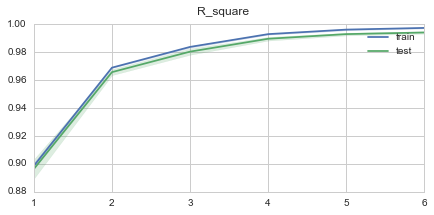

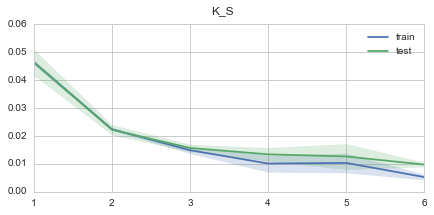

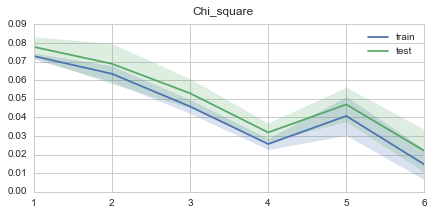

In [62]:
prop_cycle=sns.color_palette()
for column in ['R_square','K_S','Chi_square', ]:
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 3)
    plt.plot(gaussian_number_range, train_scores_mean[column],
             '-', label = 'train', color=prop_cycle[0])
    plt.fill_between(gaussian_number_range, 
                     train_scores_mean[column] - train_scores_std[column],
                     train_scores_mean[column] + train_scores_std[column], 
                     alpha=0.2, color=prop_cycle[0])
    
    plt.plot(gaussian_number_range, test_scores_mean[column],
             '-', label = 'test',color=prop_cycle[1])
    plt.fill_between(gaussian_number_range, 
                 test_scores_mean[column] - test_scores_std[column],
                 test_scores_mean[column] + test_scores_std[column], 
                 alpha=0.2,color=prop_cycle[1])
    plt.suptitle(column)
    plt.xticks(gaussian_number_range)
    plt.legend()
    plt.show()

In [63]:
import time
save_notebook()
time.sleep(3)
location_name = get_location_name(ipath)
current_file = 'time_shift.ipynb'
output_file = './output_HTML/'+location_name+'.html' 
output_HTML(current_file, output_file)

## 6.3 Variance of KDE

In [64]:
sss

NameError: name 'sss' is not defined

In [ ]:
%autosave??

In [ ]:
gmm1 = [0.552104,-0.055681,2.256591,2.757752,2.731348,0.034628,
        0.372591,2.376362,-2.098443,1.621717,2.213625,-0.01429,
        0.055879,1.009152,-1.430799,2.10049,0.808011,0.08083,
        0.019425,-0.432981,2.574572,0.784784,0.796954,-0.020531]

gmm2 = [0.552104,-0.055681,2.256591,2.757752,2.731348,0.034628,
        0.372591,2.376362,-2.098443,1.621717,2.213625,-0.01429,]

gmm3 = [0.552104,-0.055681,2.256591,2.757752,2.731348,0.034628,]

gmms = [gmm1,gmm2,gmm3]
pdfs =[]

for gmm in gmms:
    plot_gmm_ellipses(gmm)
    gmm = group_gmm_param_from_gmm_param_array(gmm) 
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    X = Y = PLOT_AXIS_RANGE
    pdf_Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument
    pdfs.append(pdf_Z)
    plot_2d_prob_density(X,Y,pdf_Z)

In [ ]:
plot_2d_prob_density(X,Y,pdfs[0]-pdfs[1])

In [ ]:
for start_time in xrange(20000000, 20150000, 50000):
    end_time = start_time + 50000 
    sub_df = df_all_years.query('(date >= @start_time) & (date < @end_time)')
    sample = sub_speed_set = array(zip(sub_df.x, sub_df.y))
    points = FITTING_RANGE
    
    # 2. KDE + EM fitting
    kde = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
    
    X = Y = PLOT_AXIS_RANGE
    kde_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde.score_samples(coords)))
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 4)
    plot_2d_prob_density(X,Y,kde_Z,ax)
    plt.show()
#     plot_speed_and_angle_distribution(sub_df.speed, sub_df.dir)

In [ ]:
# 5-fold cross validation
gaussian_number_range = arange(3,5)
CV_result_train_all,CV_result_test_all =[],[]
number_of_fold = 4
print 'Number of train/test dataset', len(df)*(number_of_fold-1)/number_of_fold, len(df)/number_of_fold

for number_of_gaussian in gaussian_number_range:
    print '  '
    print 'Number of gaussian', number_of_gaussian
    
    kf = KFold(len(df), n_folds=number_of_fold, shuffle=True) 

    CV_result_train, CV_result_test = [],[]
    for train_index, test_index in kf:
        sub_df, sub_df_test = df.iloc[train_index], df.iloc[test_index]

        # 1. Train
        result = fit_gmm(sub_df, number_of_gaussian, fit_method = FIT_METHOD)
        gmm_pdf_result_train = result['gmm_pdf_result']
        kde_train = result['kde_clf']
        kde_result_train = result['kde_result']

        # 2. Validate
        # GMM from Train - KDE from Test
        sample = array(zip(sub_df_test.x, sub_df_test.y))
        kde_test = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
        kde_result_test = exp(kde_test.score_samples(points))

        gof_train = goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_train,)
        gof_test =  goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_test,)
                
        # Plot jPDF
        X = Y = PLOT_AXIS_RANGE
        kde_train_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde_train.score_samples(coords)))
        fig = plt.figure(figsize=(22,6))
        ax1 = fig.add_subplot(1,3,1)
        plot_2d_prob_density(X,Y,kde_train_Z, ax1)
        
        ax2 = fig.add_subplot(1,3,2)
        kde_test_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde_test.score_samples(coords)))
        plot_2d_prob_density(X,Y,kde_test_Z, ax2)
            
        ax3 = fig.add_subplot(1,3,3)
        plot_2d_prob_density(X,Y,kde_train_Z-kde_test_Z,ax3)
        
        pretty_pd_display([gof_train, gof_test], index=["gof_train", "gof_test"]))
        